In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import sys
sys.path.insert(0, os.path.abspath('../Libraries'))
import countries as cLib

In [8]:
df = pd.read_csv('../Datasets/cleaned_Productivity.csv')
df.drop('mean', axis=1, inplace=True)
df_formatted = pd.melt(df, id_vars = ['LOCATION'], var_name = 'YEAR', value_name= 'PRODUCTIVITY')
df_formatted = df_formatted.sort_values(['LOCATION', 'YEAR'], ascending=[True, True])
df_formatted = df_formatted.reset_index(drop=True)
df_formatted['YEAR'] = pd.to_numeric(df_formatted['YEAR'])

In [9]:
# Figure out year to predict
years = df_formatted['YEAR'].unique()
year_to_predict = years[round(len(years)*0.8)]
print(year_to_predict)

2018


# Per country

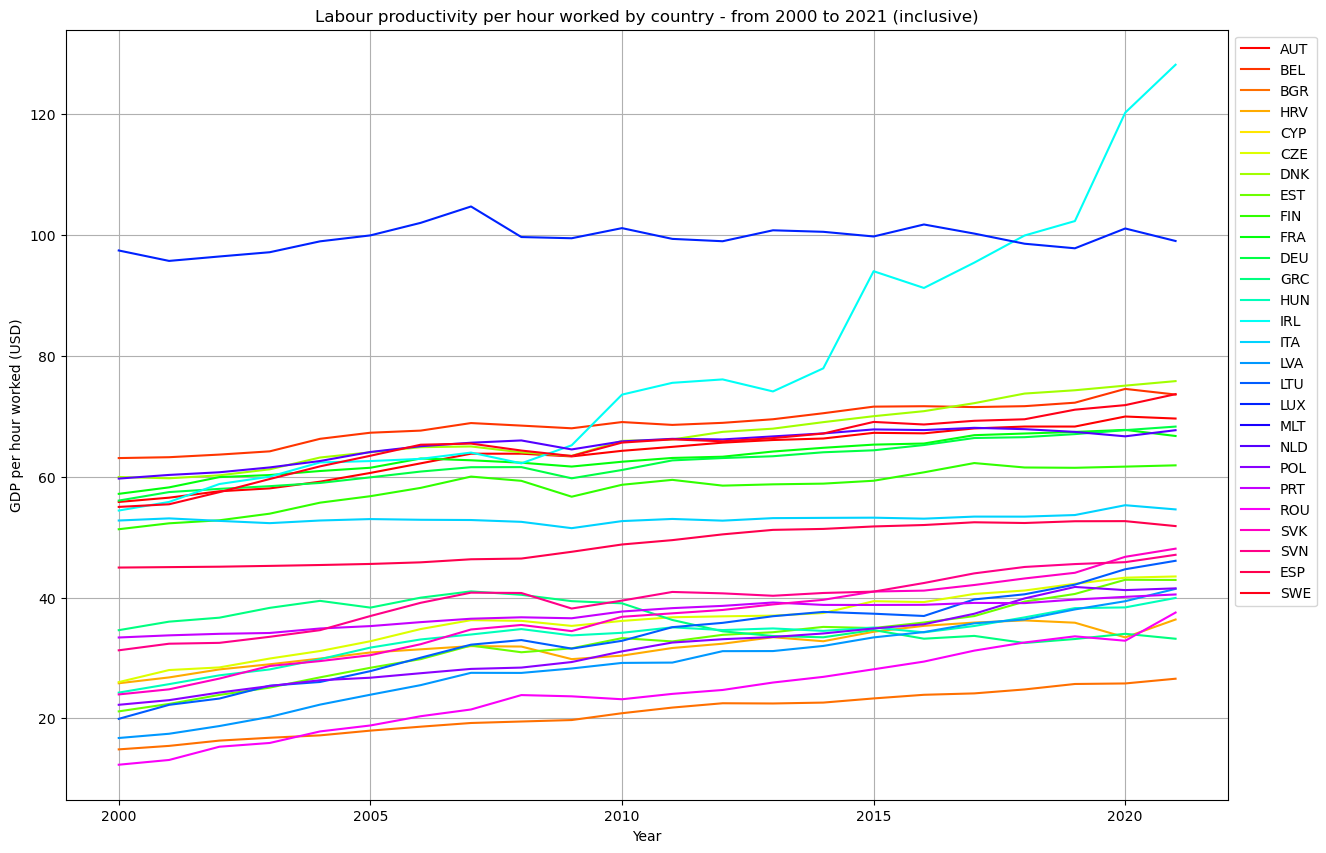

In [10]:
# Plot the data
plt.subplots(figsize=(15, 10))
countries = cLib.get_countries()
colors = plt.cm.hsv(np.linspace(0, 1, len(countries)))
years_xticks = [int(year) for year in df_formatted['YEAR']]

for i, country in enumerate(countries):
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    plt.plot(country_data['YEAR'], country_data['PRODUCTIVITY'], color=colors[i], label=country_code)
    
plt.grid()
# plt.xticks(years_xticks)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel("Year")
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by country - from 2000 to 2021 (inclusive)")
plt.show()

## Exponential smoothing

In [17]:
# REFERENCE: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
def plot_smoothed_data(name, series, index):
    # Smooth series and predict 5 years ahead
    pred_date_start = 2021
    pred_date_end = 2021 + 5
    index_pred = pd.date_range(start=str(pred_date_start), end=str(pred_date_end), freq='AS')

    # Simple Exponential Smoothing (SES)
    fit = SimpleExpSmoothing(series, initialization_method="estimated").fit()
    forecast = fit.forecast(5)
    ses_smoothed = fit.fittedvalues
    ses_forecast = forecast.values
    ses_forecast = np.insert(ses_forecast, 0, ses_smoothed[-1])

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series,
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[-1])

    plt.plot(index, series, color='black', label='Actual')
    plt.plot(index, ses_smoothed, color='red', label='SES smoothing', linestyle='--')
    plt.plot(index_pred, ses_forecast, color='red', label='SES forecast', linestyle='dotted')
    plt.plot(index, exp_smoothed, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
    plt.plot(index_pred, exp_forecast, color='blue', label="Holt's Linear Trend forecast", linestyle='dotted')
    plt.axvline(x=pd.to_datetime(2021, format="%Y"), color='gray', linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
    plt.xlabel("Year")
    plt.ylabel('GDP per hour worked (USD)')
    plt.title(f"Labour productivity per hour worked by {name} - from 2000 to 2021 (inclusive)")
    plt.show()

In [12]:
# Get the mean data for each year
path = "../Datasets/cleaned_Productivity.csv"
df_labour = pd.read_csv(path)
df_labour.rename(columns=lambda x: int(x) if x.isdigit() else x, inplace=True)
df_labour.drop(columns=['mean'], inplace=True)
df_labour = df_labour[df_labour['LOCATION'].isin(cLib.get_alpha_3_list())]
df_labour.reset_index(drop=True, inplace=True)
df_labour_mean = df_labour.mean(numeric_only=True, axis=0)
df_labour_mean = pd.DataFrame(df_labour_mean, columns=['PRODUCTIVITY'])
df_labour_mean.index.freq = 'AS'

df_labour_mean = df_labour_mean[df_labour_mean.index >= 2000]

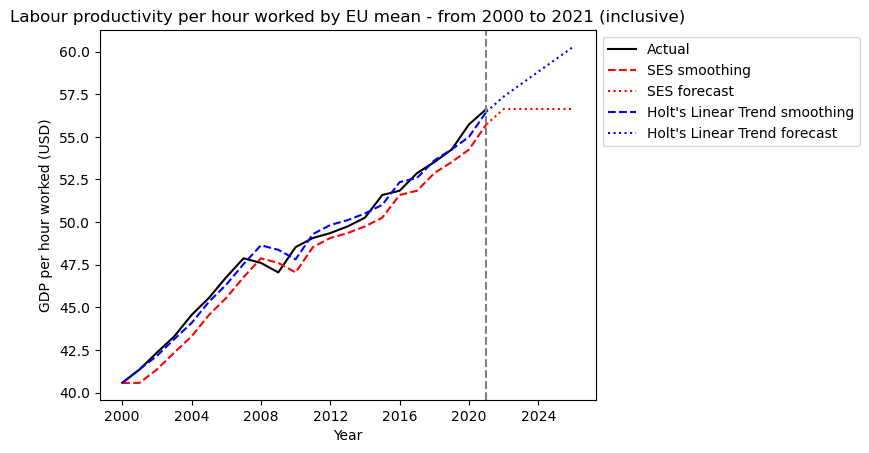

In [18]:
# Exponential smoothing
index = pd.date_range(start='2000', end='2021', freq='AS')
labour_mean_series = pd.Series(df_labour_mean['PRODUCTIVITY'].values, index=index)
plot_smoothed_data("EU mean", labour_mean_series, index)

Due to the horizontal line from the SES prediction (SES assumes that the time series has an underlying constant level), it is clearly a poor choice for predicting, so the general exponential smoothing will be used instead

Let's see if we limit the time series up to a certain point (80% of the data), can it predict accurately up to 2021?

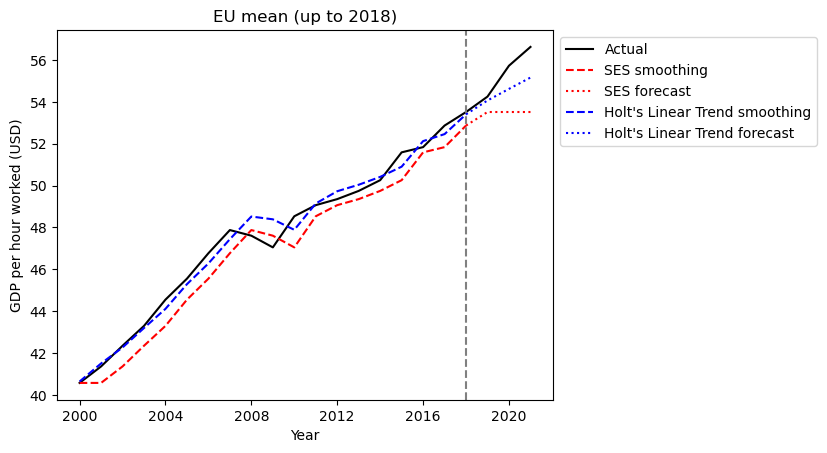

In [23]:
def plot_smoothed_data_past(title, series, index, pred_date_start=2022):
    # Smooth series and predict 5 years ahead
    pred_date_end = 2021
    actual_time = pred_date_start - 2000 + 1
    prediction_time = pred_date_end - pred_date_start
    index_actual = pd.date_range(start='2000', end=str(pred_date_start), freq='AS')
    index_pred = pd.date_range(start=str(pred_date_start), end=str(pred_date_end), freq='AS')

    # Simple Exponential Smoothing (SES)
    fit = SimpleExpSmoothing(series[:actual_time], initialization_method="estimated").fit()
    forecast = fit.forecast(prediction_time)
    ses_smoothed = fit.fittedvalues
    ses_forecast = forecast.values
    ses_forecast = np.insert(ses_forecast, 0, ses_smoothed[-1])

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series[:actual_time],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(prediction_time)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[-1])

    plt.plot(index, series, color='black', label='Actual')
    plt.plot(index_actual, ses_smoothed, color='red', label='SES smoothing', linestyle='--')
    plt.plot(index_pred, ses_forecast, color='red', label='SES forecast', linestyle='dotted')
    plt.plot(index_actual, exp_smoothed, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
    plt.plot(index_pred, exp_forecast, color='blue', label="Holt's Linear Trend forecast", linestyle='dotted')
    plt.axvline(x=pd.to_datetime(year_to_predict, format="%Y"), color='gray', linestyle='--')
    
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
    plt.xlabel("Year")
    plt.ylabel('GDP per hour worked (USD)')
    plt.title(title)
    plt.show()
plot_smoothed_data_past("EU mean (up to "+str(year_to_predict)+")", labour_mean_series, index, pred_date_start=year_to_predict)

Let's test on all of the countries separately

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


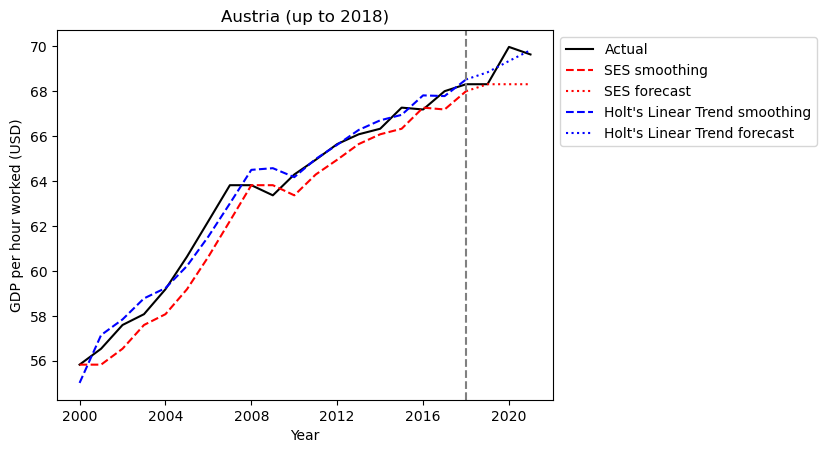

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


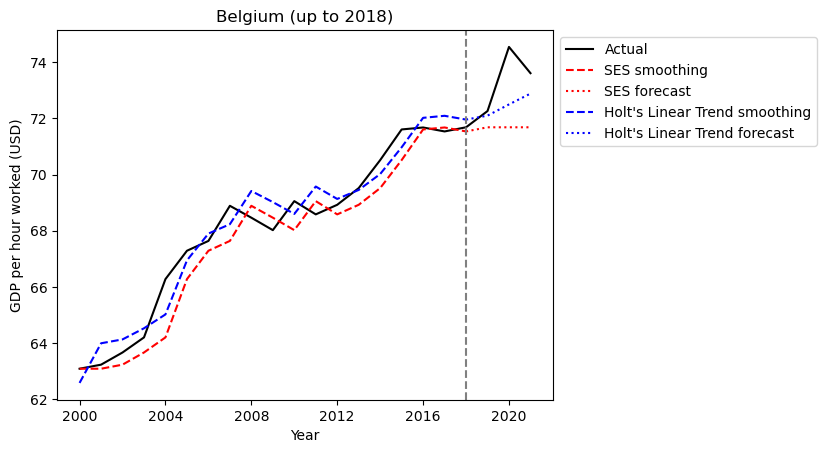

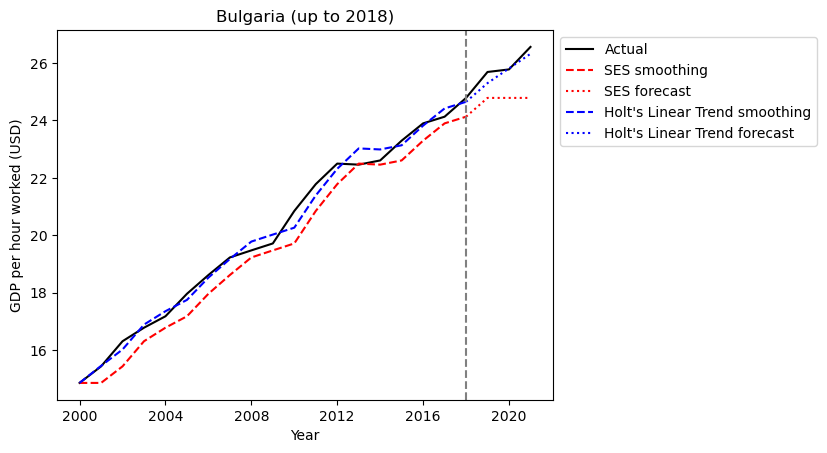

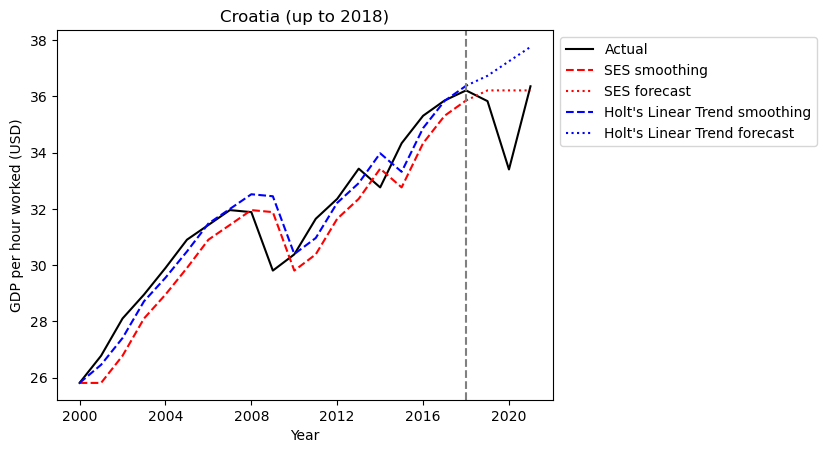

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


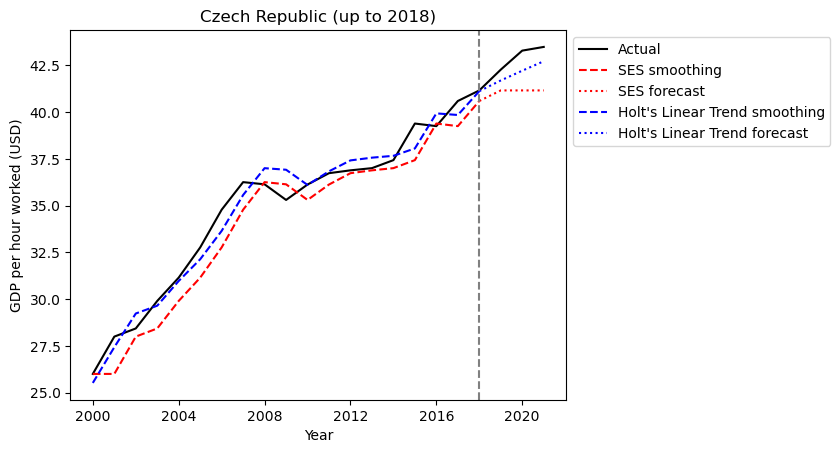

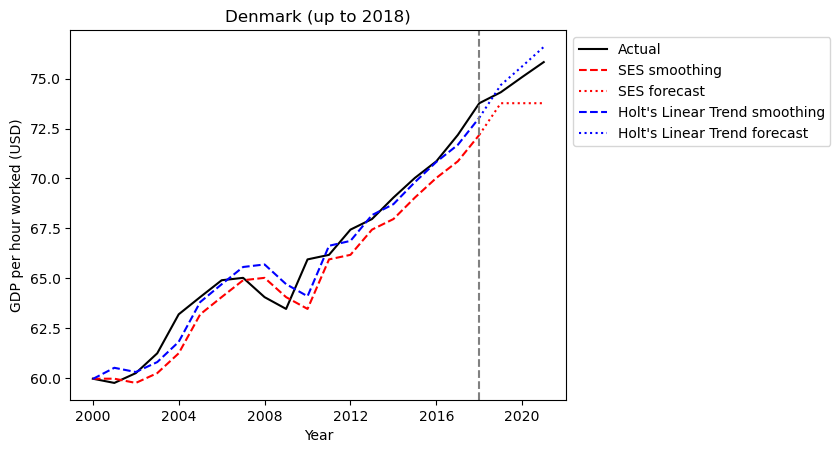

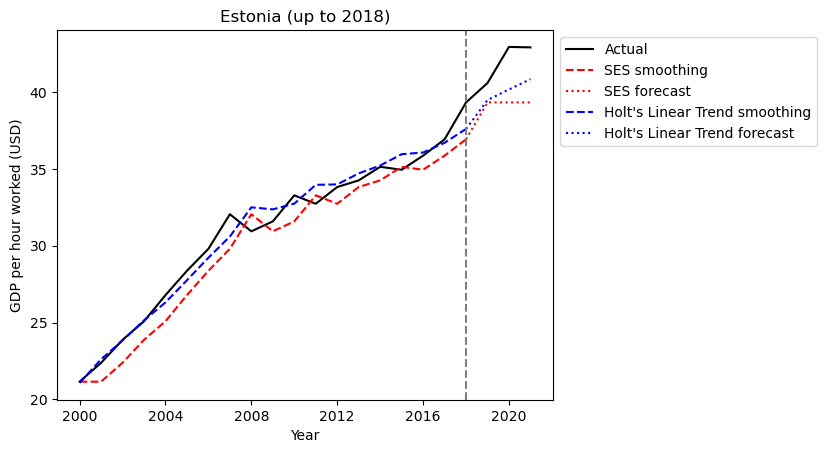

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


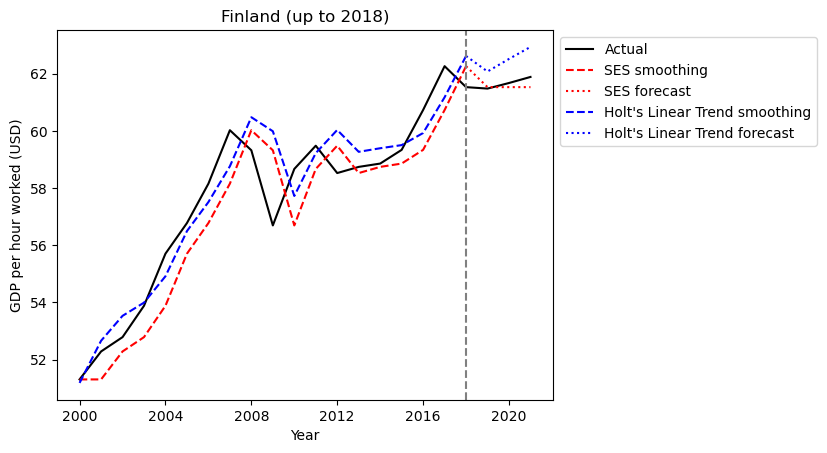

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


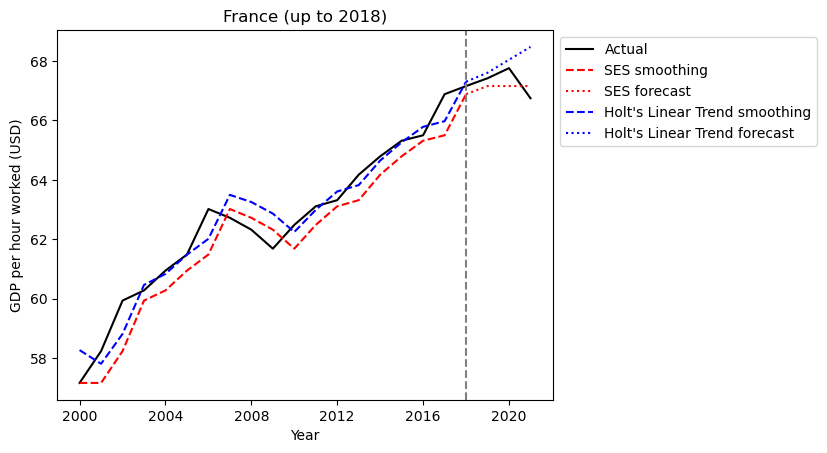

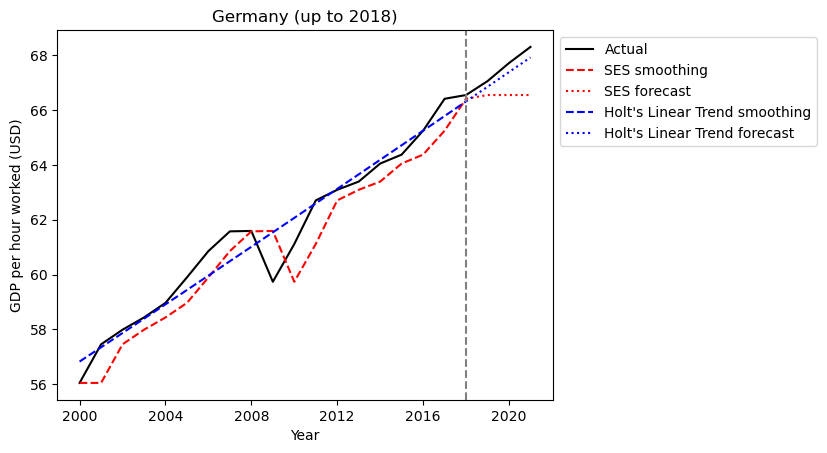

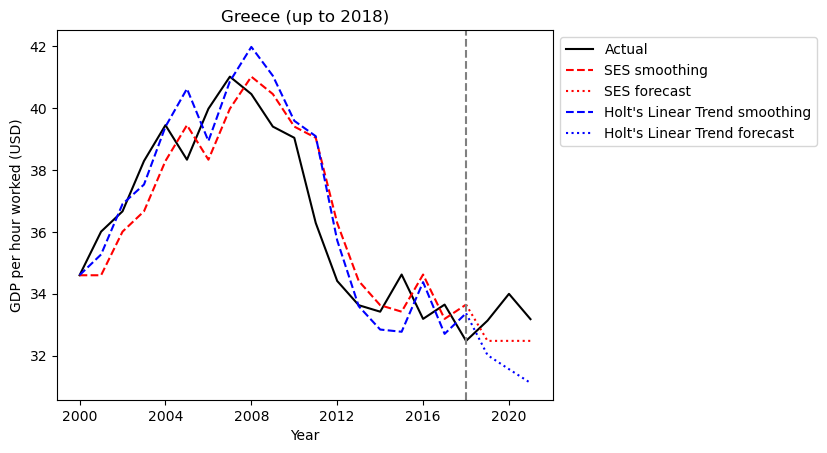

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


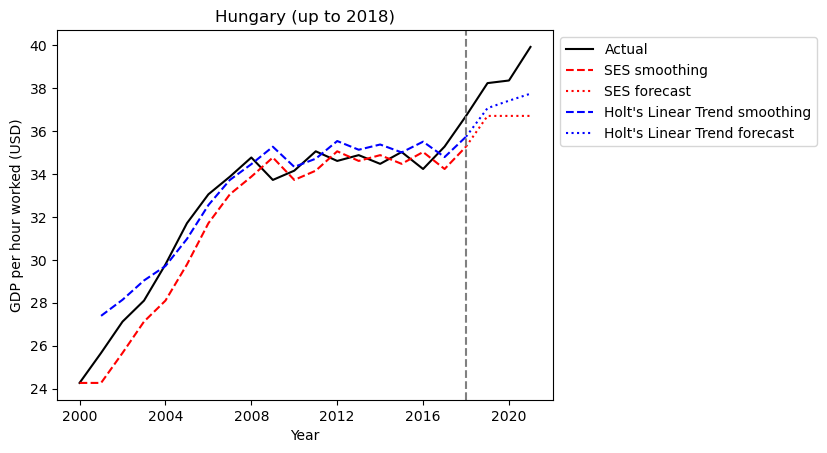

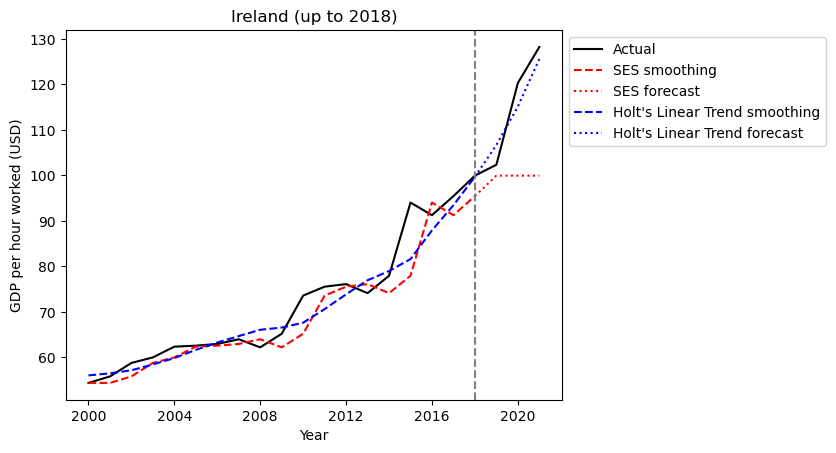

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


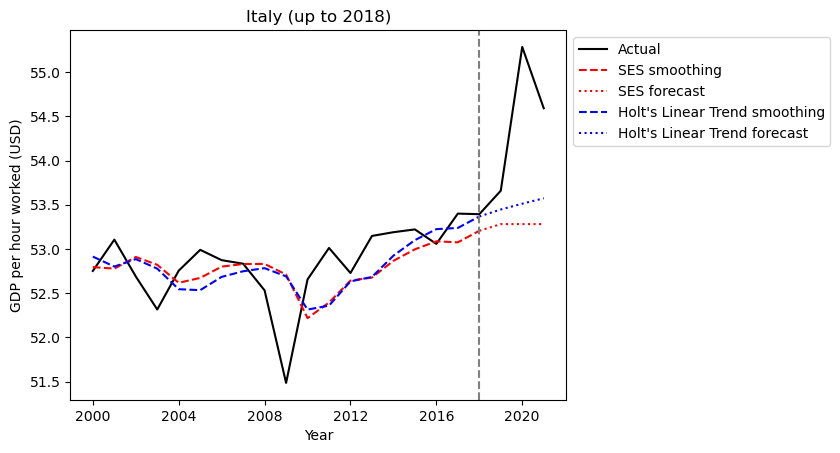

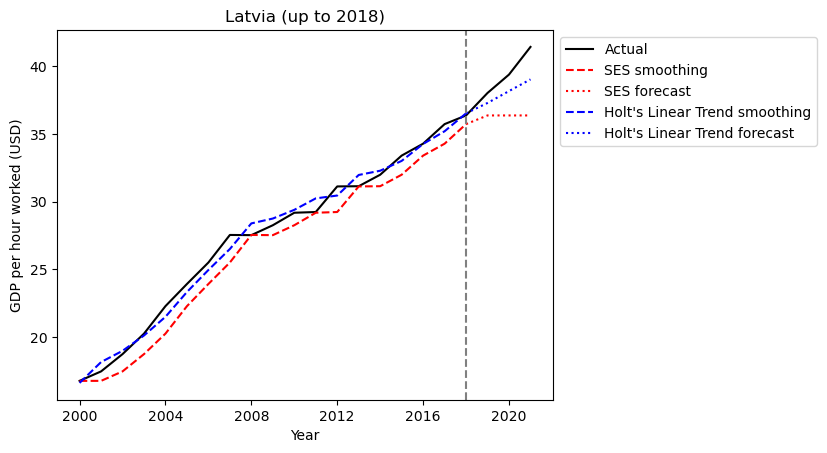

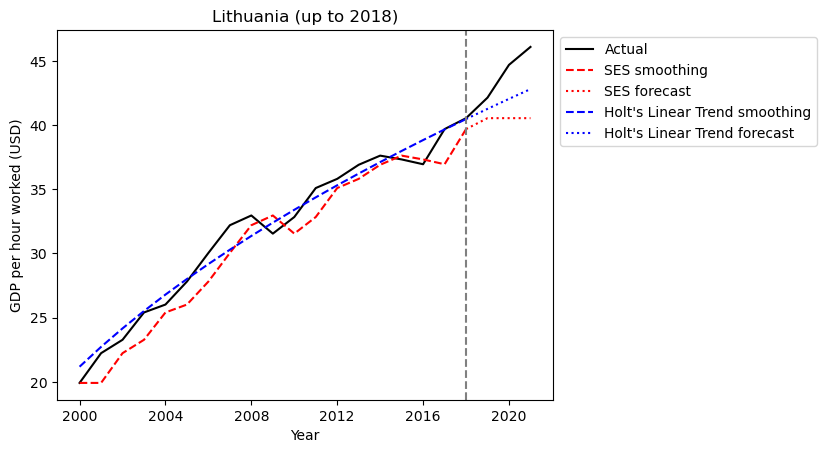

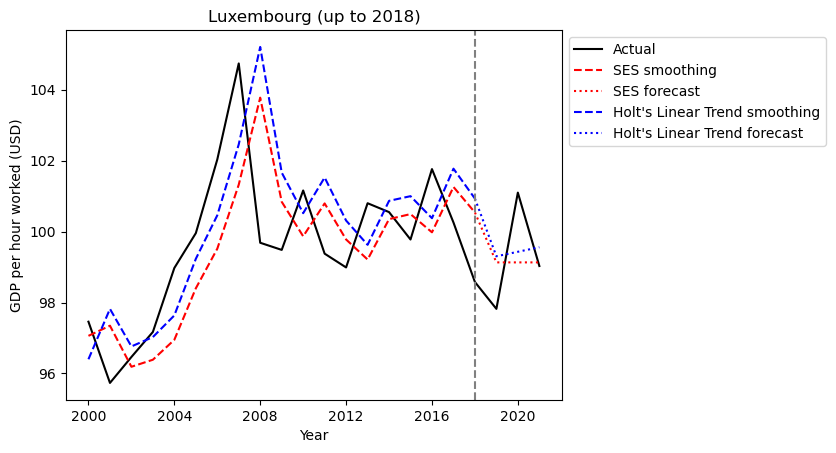

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


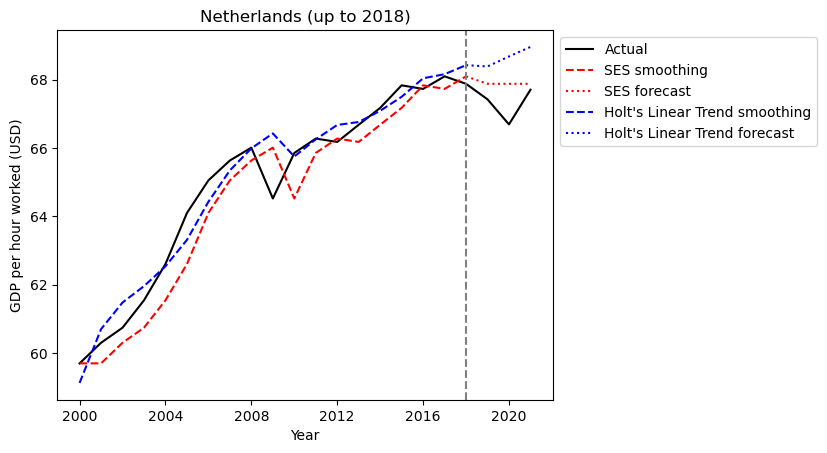

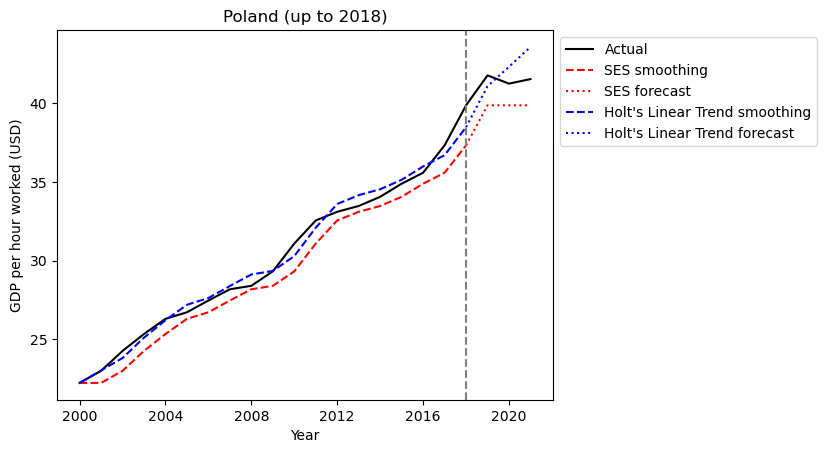

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


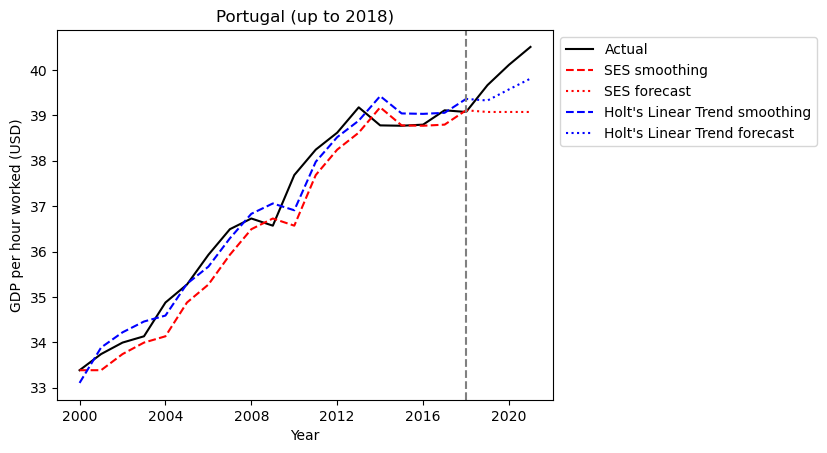

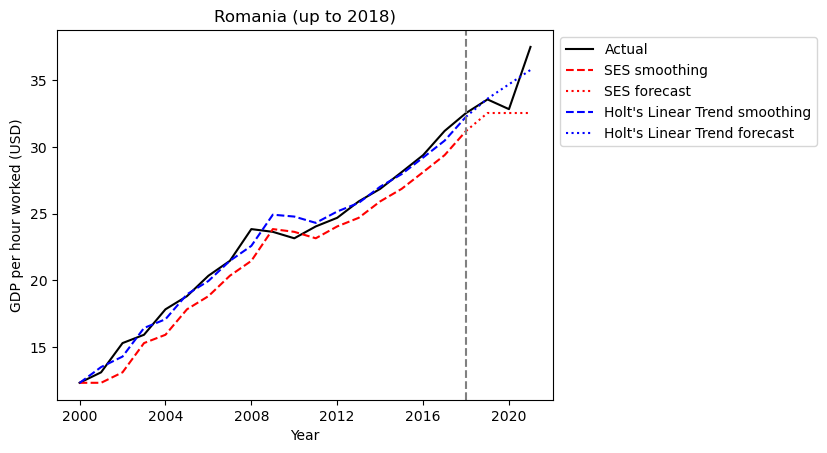

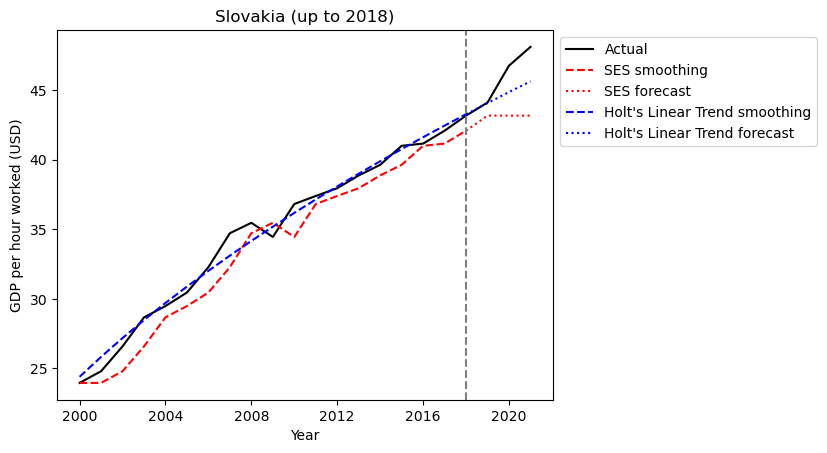

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


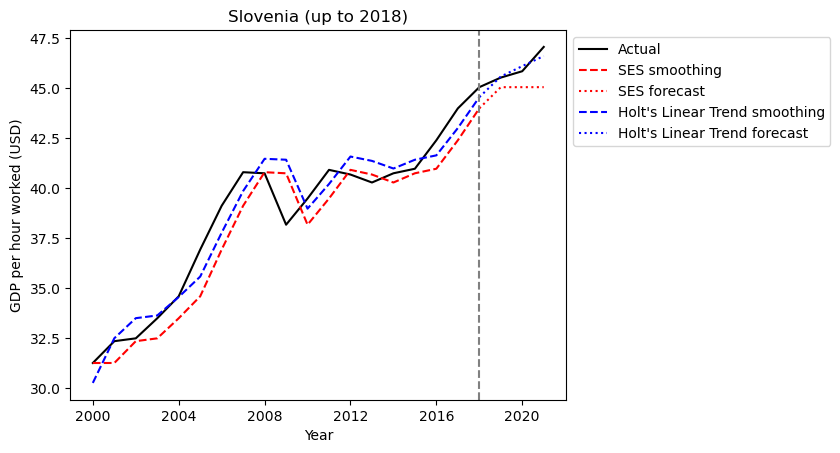

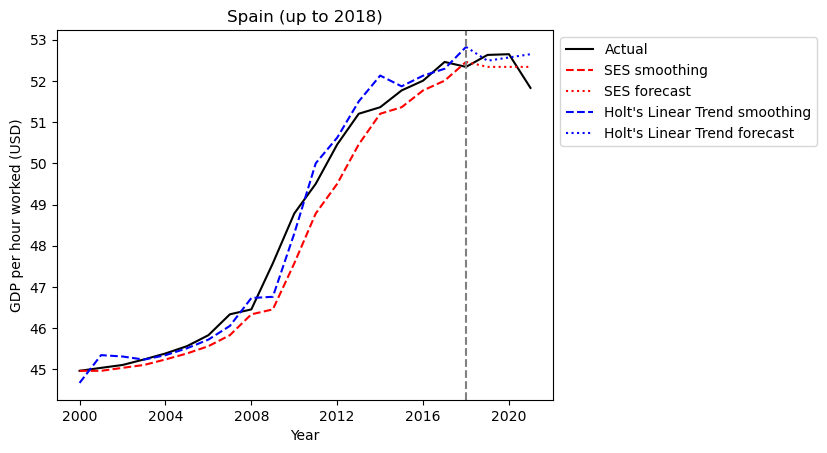

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


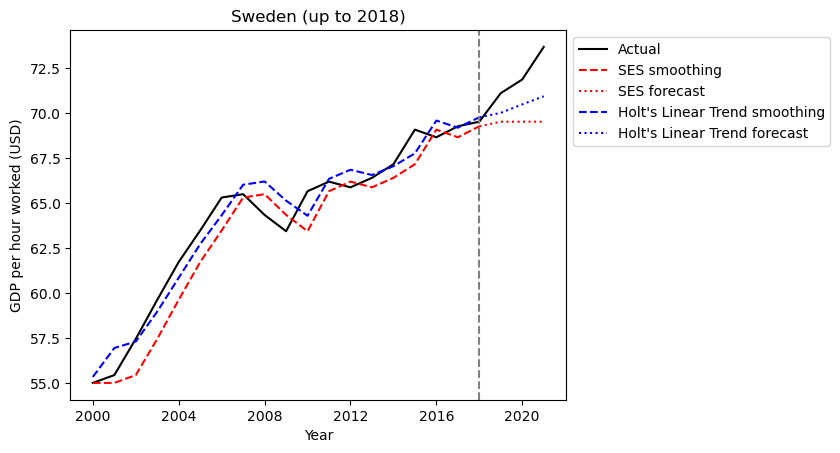

In [24]:
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Plot the data
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    plot_smoothed_data_past(country+" (up to "+str(year_to_predict)+")", country_series, index, pred_date_start=year_to_predict)

The issue with using Exponential Smoothing is that it seems to push the trends forwards in time (see 2009). So while it can do a decent job at predicting the future, it probably is not a good choice for filling in missing data.

Furthermore, it isn't that great at predicting the future, so going to look into ARIMA

## ARIMA

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -18.538
Date:                Sun, 09 Apr 2023   AIC                             43.075
Time:                        15:37:35   BIC                             46.209
Sample:                    01-01-2000   HQIC                            43.755
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.010     95.448      0.000       0.979       1.021
ma.L1         -0.9922      2.672     -0.371      0.710      -6.229       4.245
sigma2         0.2882      0.779      0.370      0.7

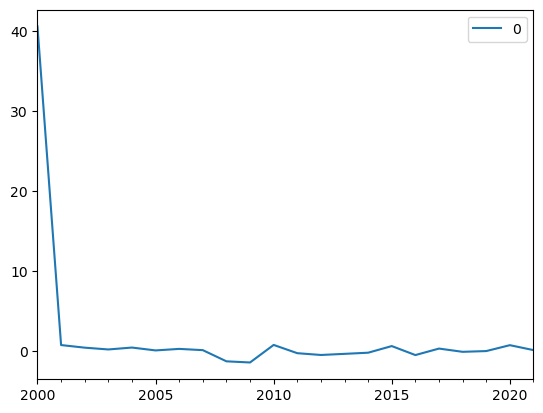

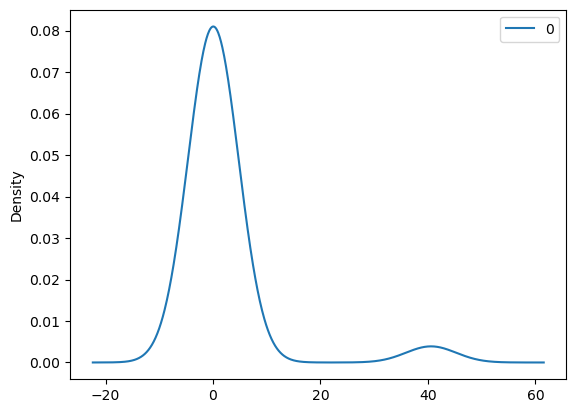

               0
count  22.000000
mean    1.891077
std     8.658106
min    -1.386748
25%    -0.211879
50%     0.155958
75%     0.473321
max    40.567788


In [25]:
# REFERENCE: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def plot_arima_residual_errors(series, arima_order=(1, 1, 1)):
    # ARIMA
    model = ARIMA(series, order=arima_order)
    model_fit = model.fit()
    print(model_fit.summary())

    # Plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    # Plot density plot of residual errors
    residuals.plot(kind='kde')
    plt.show()

    print(residuals.describe())
plot_arima_residual_errors(labour_mean_series)

As seen in those graphs, looks like there shouldn't be much residual errors, only at the start, so let's try to predict the future with it

In [26]:
# Evaluate an ARIMA model using a walk-forward validation
def run_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = year_to_predict - 2000 + 1 # train up to and including year_to_predict
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    results = {
        "train": train,
        "test": test,
        "predictions": predictions,
        "train_size": train_size,
        "history": history
    }
    return results

def plot_arima_model(title, X, arima_order, test_only=False):
    results = run_arima_model(X, arima_order)
    train_size = results["train_size"]
    train = results["train"]
    test = results["test"]
    predictions = results["predictions"]

    # Plot graph
    if not test_only:
        # Add the year_to_predict value to the predictions
        predictions = np.insert(predictions, 0, train[-1])

        plt.plot(index, X, color='black', label='Actual')
        plt.plot(index[train_size-1:], predictions, color='red', label='Predictions', linestyle='--')
        plt.axvline(x=pd.to_datetime(year_to_predict, format="%Y"), color='gray', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()
    else:
        years = [str(i) for i in range(2000, 2022)]
        plt.plot(years[train_size:], test, color='black', label='Actual')
        plt.plot(years[train_size:], predictions, color='red', label='Predictions', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()

def evaluate_arima_model(X, arima_order):
    results = run_arima_model(X, arima_order)
    test = results["test"]
    predictions = results["predictions"]
    
    # Calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

Let's try to tune the parameters to get the best hyperparameters

In [27]:
# Tune the ARIMA model
# REFERENCE: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    # print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(labour_mean_series, p_values, d_values, q_values)

Best ARIMA(4, 2, 0) MSE=0.133


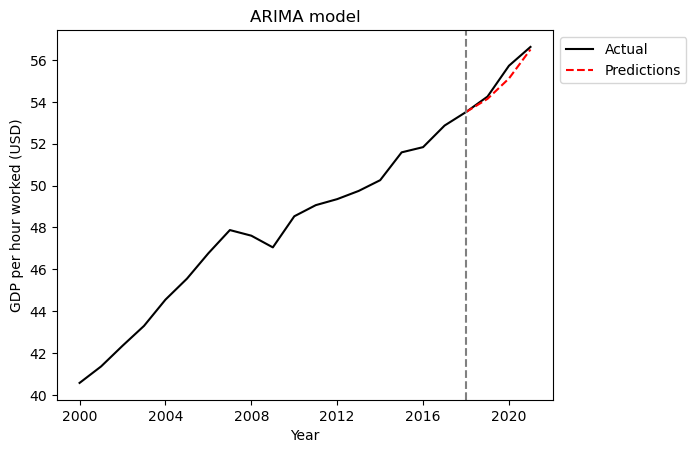

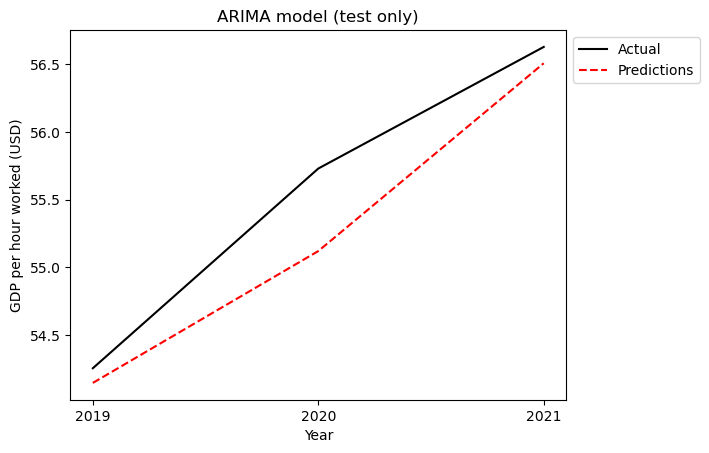

In [28]:
# Plot the best ARIMA model
plot_arima_model("ARIMA model", labour_mean_series, best_cfg)
plot_arima_model("ARIMA model (test only)", labour_mean_series, best_cfg, test_only=True)

And looking back at the residual errors with the best hyperparameters...

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                 ARIMA(4, 2, 0)   Log Likelihood                 -16.916
Date:                Sun, 09 Apr 2023   AIC                             43.833
Time:                        15:38:03   BIC                             48.811
Sample:                    01-01-2000   HQIC                            44.804
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7430      0.214     -3.468      0.001      -1.163      -0.323
ar.L2         -0.7531      0.230     -3.273      0.001      -1.204      -0.302
ar.L3         -0.4342      0.507     -0.857      0.3

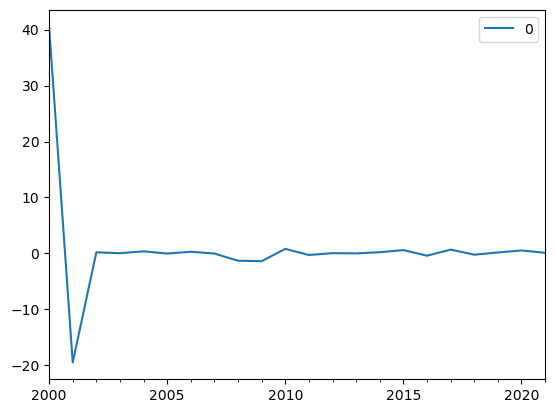

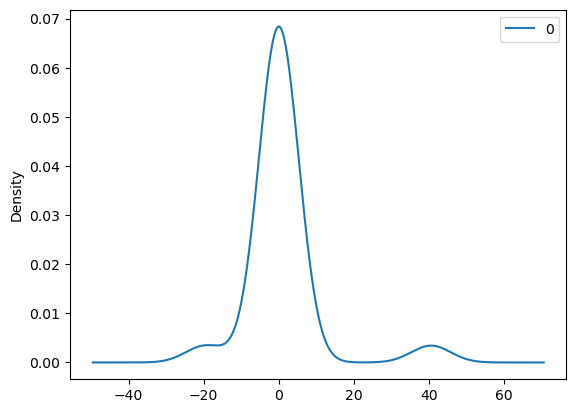

               0
count  22.000000
mean    0.976697
std     9.785542
min   -19.496123
25%    -0.175521
50%     0.078477
75%     0.354584
max    40.567788


In [29]:
# REFERENCE: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
plot_arima_residual_errors(labour_mean_series, arima_order=best_cfg)

Looking pretty good, let's try it on each country

In [30]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

country_arima_orders = {}
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Find best ARIMA model for each country
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    country_cfg = evaluate_models(country_series, p_values, d_values, q_values)
    country_arima_orders[country] = country_cfg

Best ARIMA(4, 2, 2) MSE=0.348
Best ARIMA(0, 2, 1) MSE=1.840
Best ARIMA(0, 2, 1) MSE=0.137
Best ARIMA(10, 2, 1) MSE=3.313
Best ARIMA(6, 1, 1) MSE=0.028
Best ARIMA(1, 1, 1) MSE=0.011
Best ARIMA(2, 1, 0) MSE=0.922
Best ARIMA(1, 1, 0) MSE=0.028
Best ARIMA(1, 0, 0) MSE=0.393
Best ARIMA(0, 2, 2) MSE=0.002
Best ARIMA(1, 0, 0) MSE=0.506
Best ARIMA(10, 2, 1) MSE=0.358
Best ARIMA(6, 2, 1) MSE=32.963
Best ARIMA(10, 2, 1) MSE=0.238
Best ARIMA(10, 1, 2) MSE=0.149
Best ARIMA(0, 2, 2) MSE=0.680
Best ARIMA(0, 0, 0) MSE=2.015
Best ARIMA(1, 0, 0) MSE=0.586
Best ARIMA(8, 1, 1) MSE=0.929
Best ARIMA(0, 2, 2) MSE=0.037
Best ARIMA(1, 2, 2) MSE=5.136
Best ARIMA(0, 2, 1) MSE=0.863
Best ARIMA(6, 2, 1) MSE=0.048
Best ARIMA(10, 0, 1) MSE=0.075
Best ARIMA(4, 2, 2) MSE=0.424


Draw exponential smoothing vs arima

In [33]:
# Plot Exponential Smoothing vs ARIMA
def plot_exp_smoothing_vs_arima(title, X, arima_order, test_only=False):
    # ARIMA
    results = run_arima_model(X, arima_order)
    train = results["train"]
    train_size = results["train_size"]
    test = results["test"]
    predictions = results["predictions"]

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        X[:train_size],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(len(test))
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    if not test_only:
        exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[:train_size])
    
    # Plot graph
    if not test_only:
        # Add the year_to_predict value to the predictions
        predictions = np.insert(predictions, 0, train[-1])

        plt.plot(index, X, color='black', label='Actual')
        plt.plot(index, exp_forecast, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
        plt.plot(index[train_size-1:], predictions, color='red', label='ARIMA', linestyle='--')
        plt.axvline(x=pd.to_datetime(year_to_predict, format="%Y"), color='gray', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()
    else:
        years = [str(i) for i in range(2000, 2022)]
        plt.plot(years[train_size:], test, color='black', label='Actual')
        plt.plot(years[train_size:], exp_forecast, color='blue', label="Holt's Linear Trend smoothing", linestyle='--')
        plt.plot(years[train_size:], predictions, color='red', label='ARIMA', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()

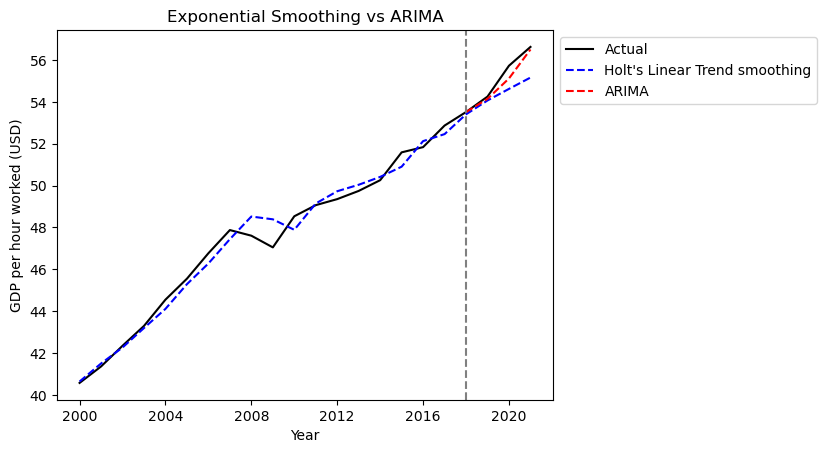

In [34]:
plot_exp_smoothing_vs_arima("Exponential Smoothing vs ARIMA", labour_mean_series, best_cfg)

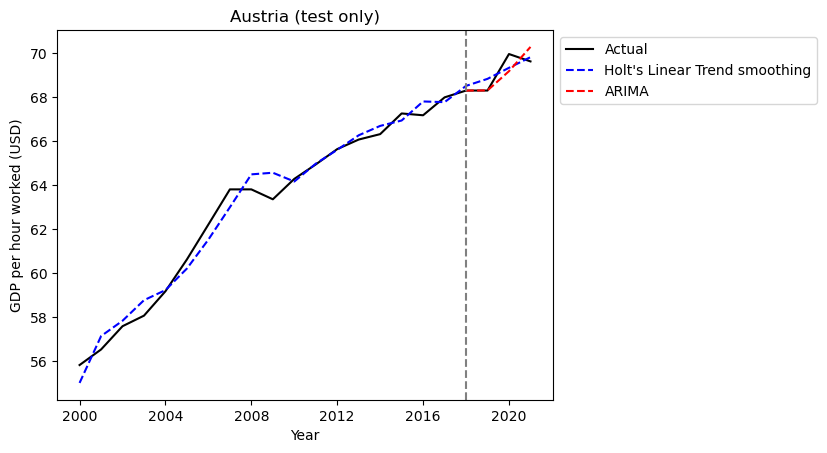

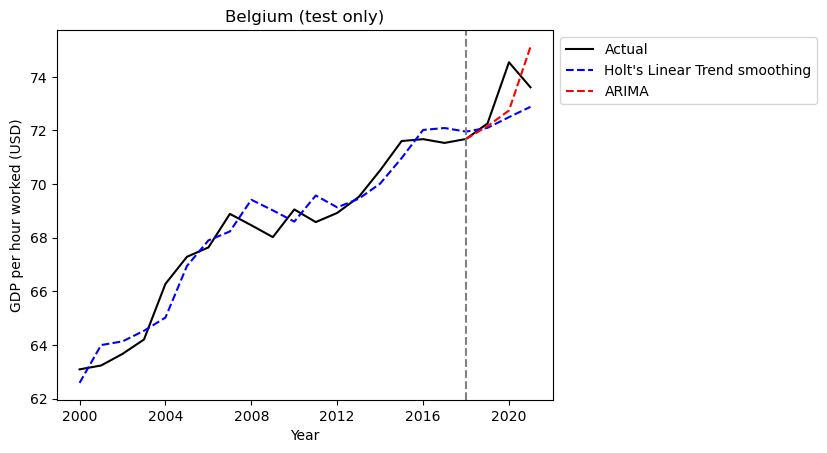

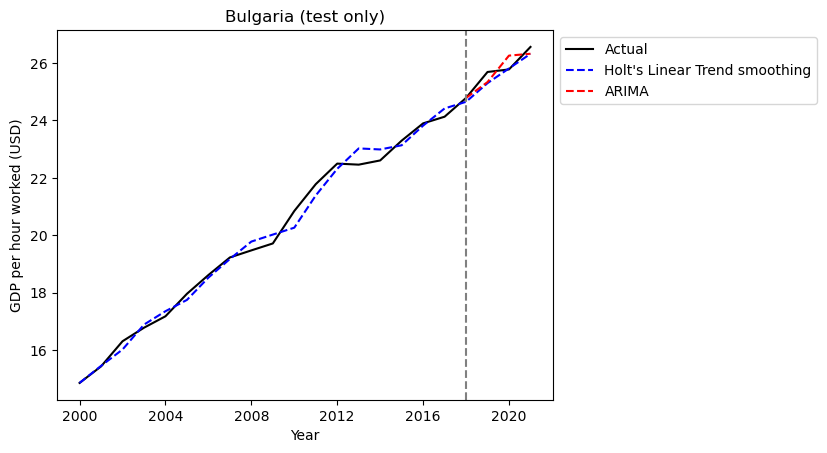

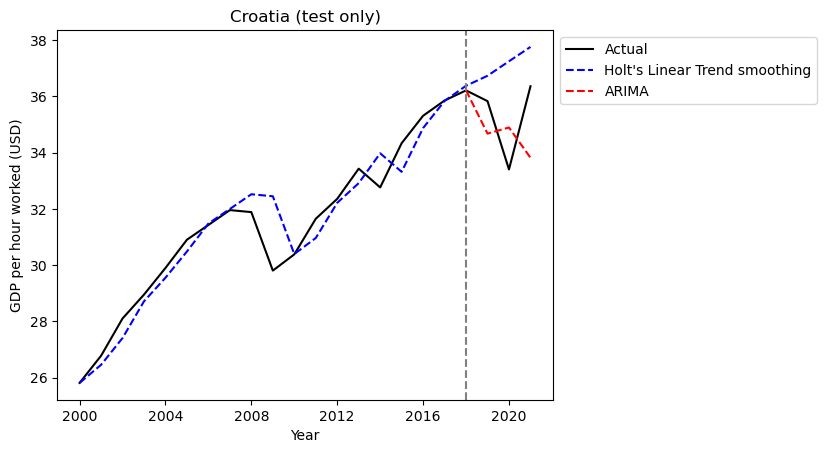

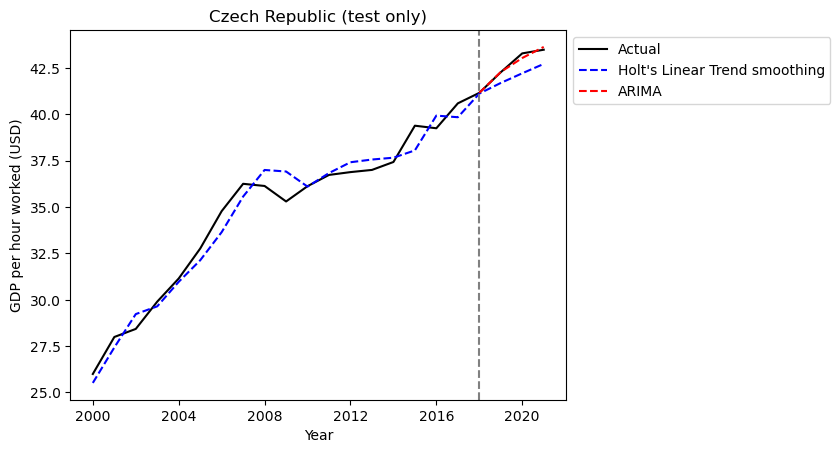

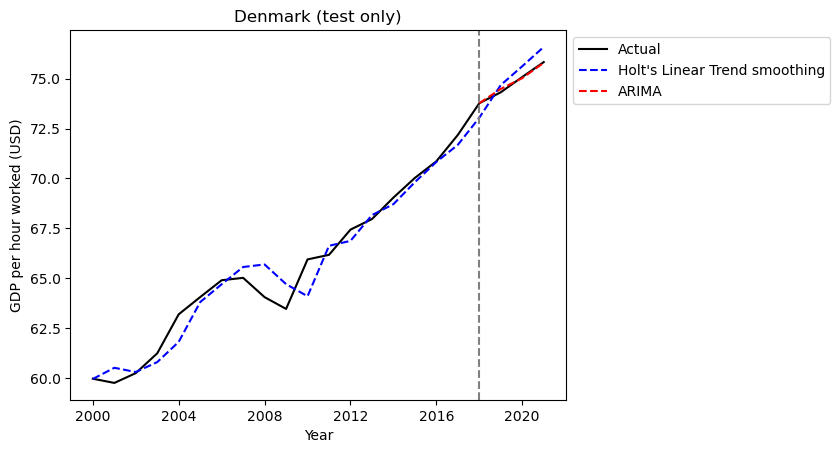

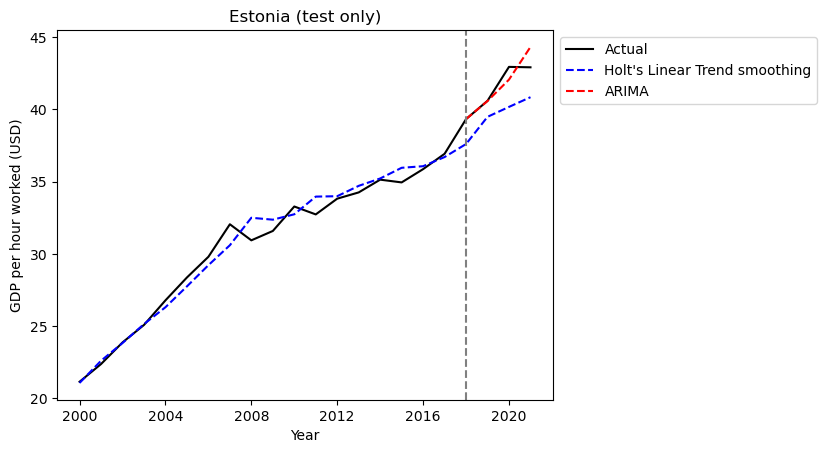

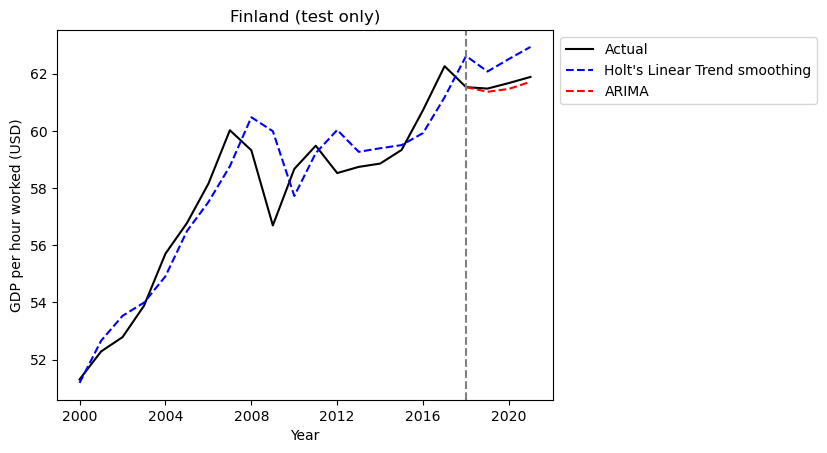

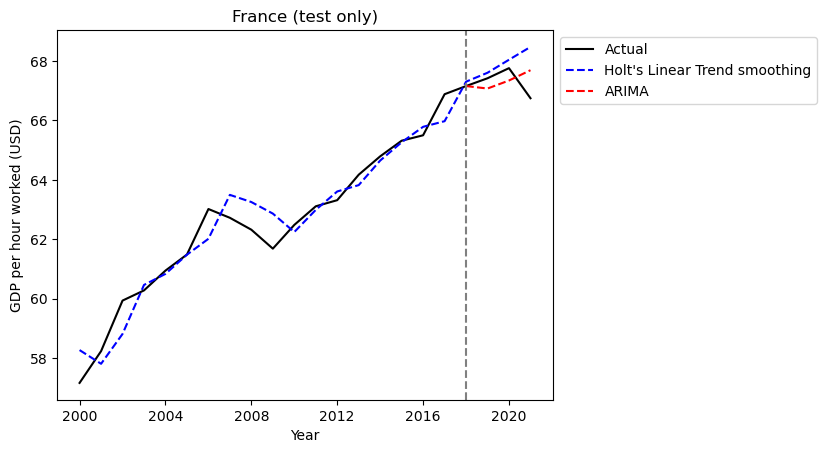

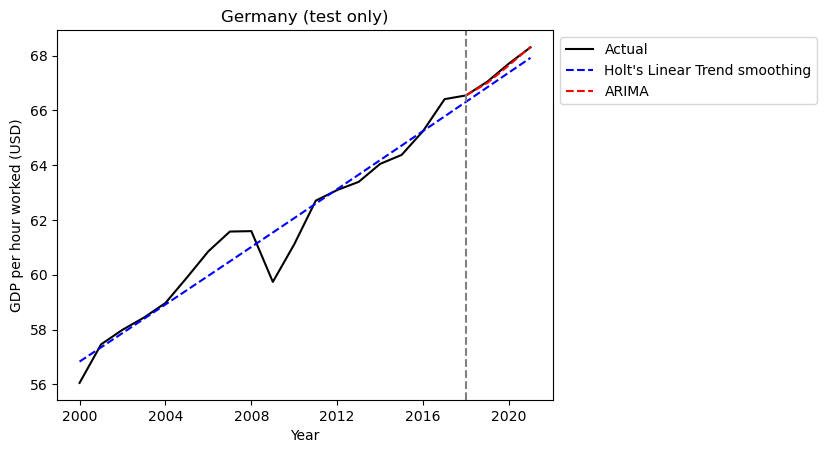

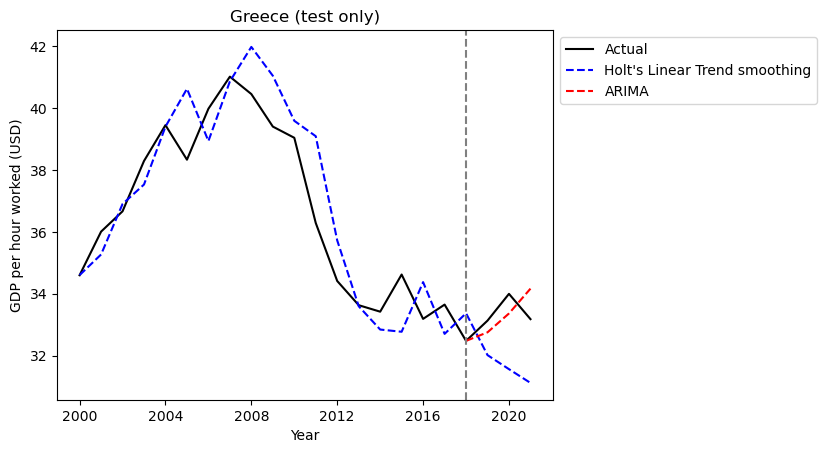

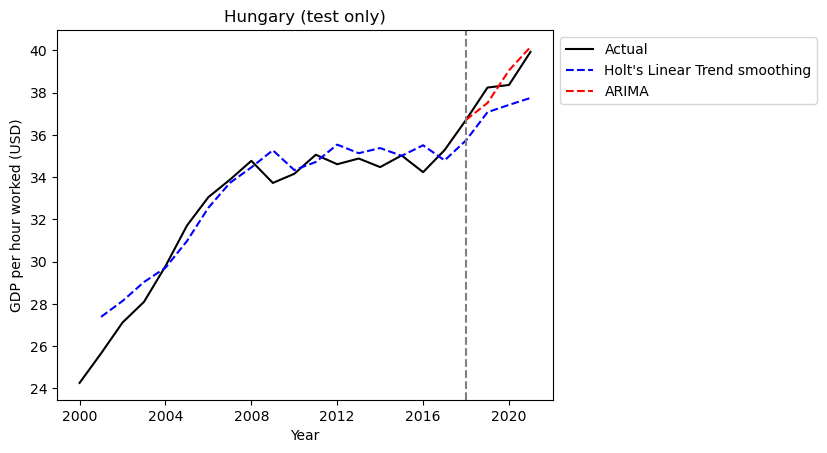

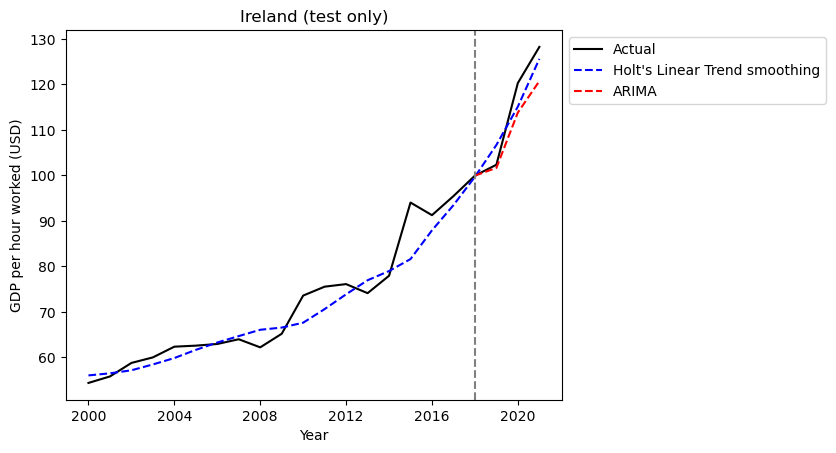

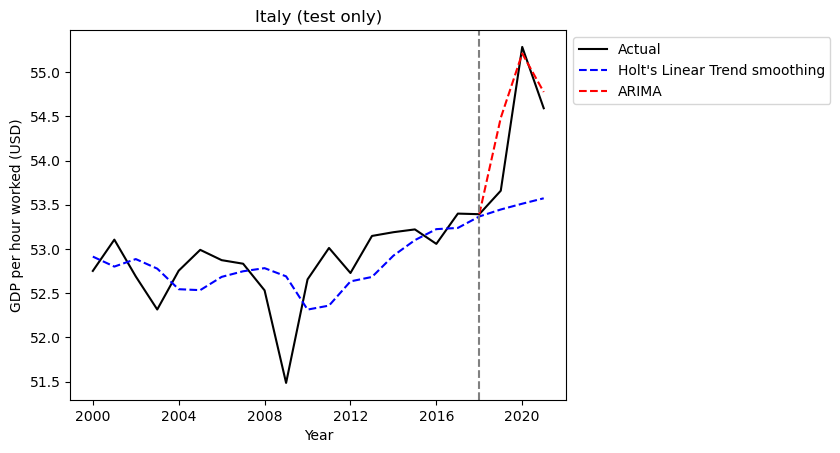

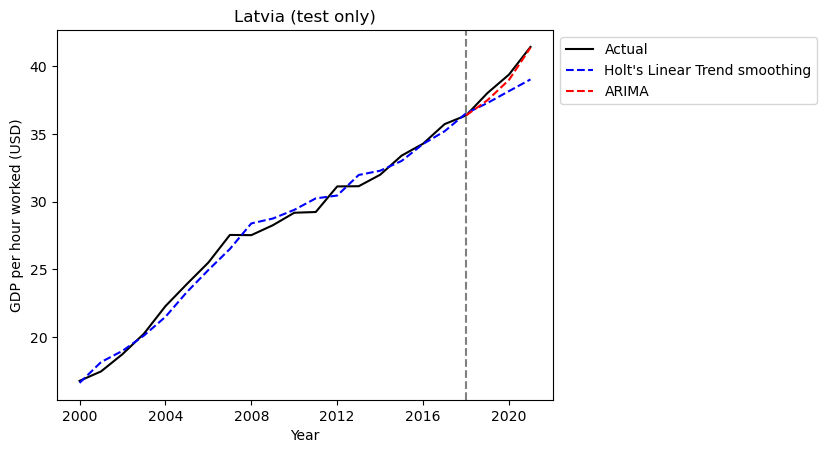

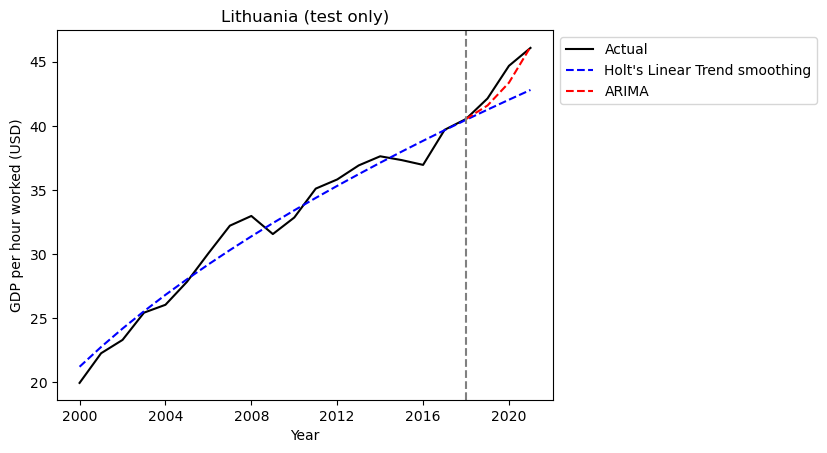

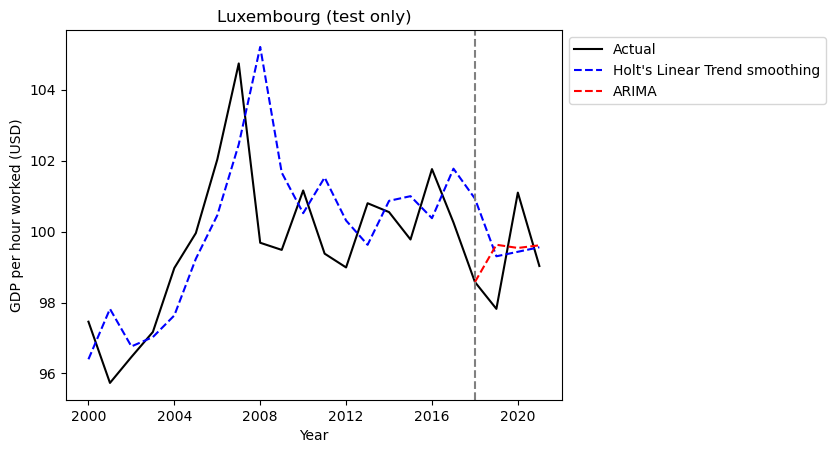

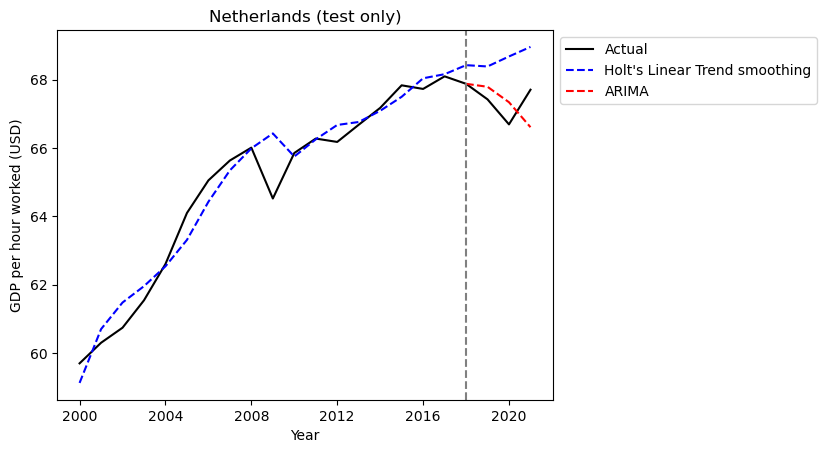

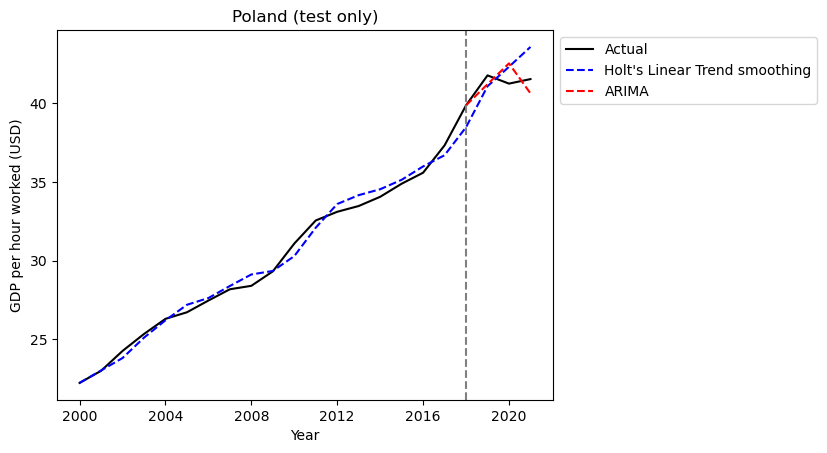

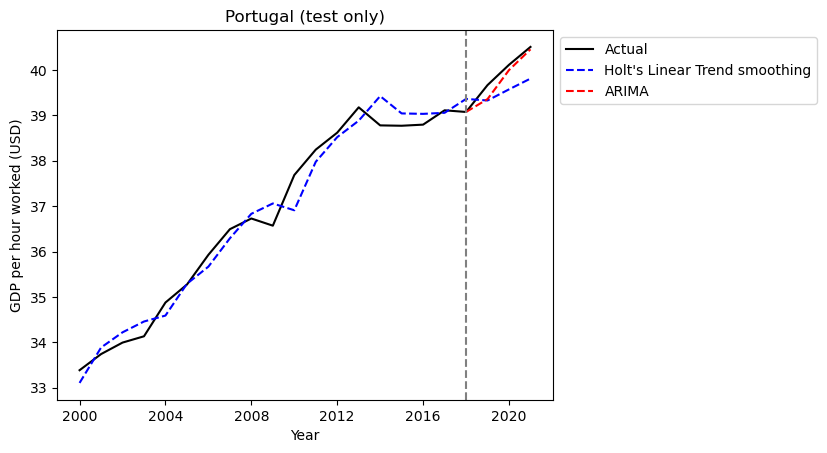

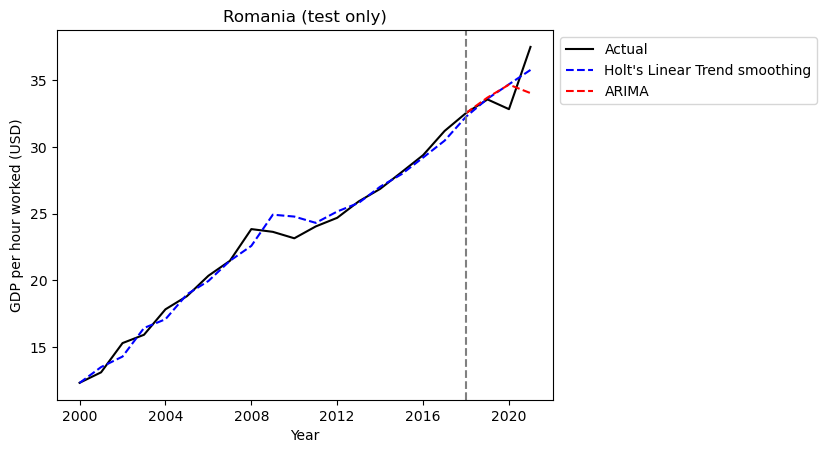

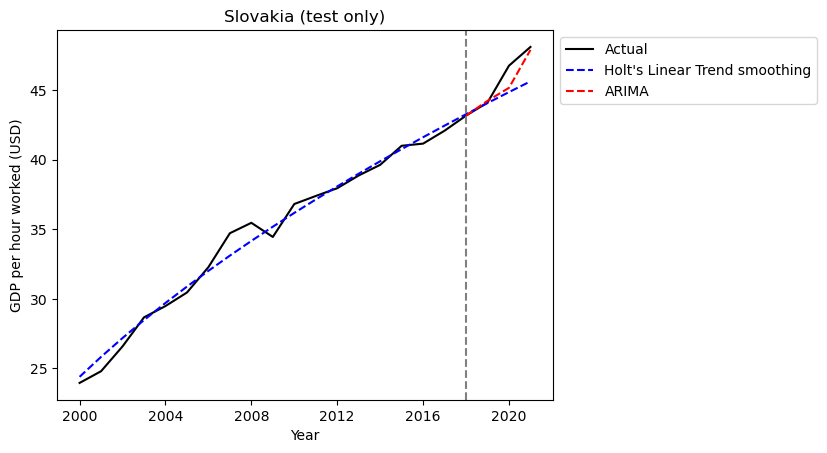

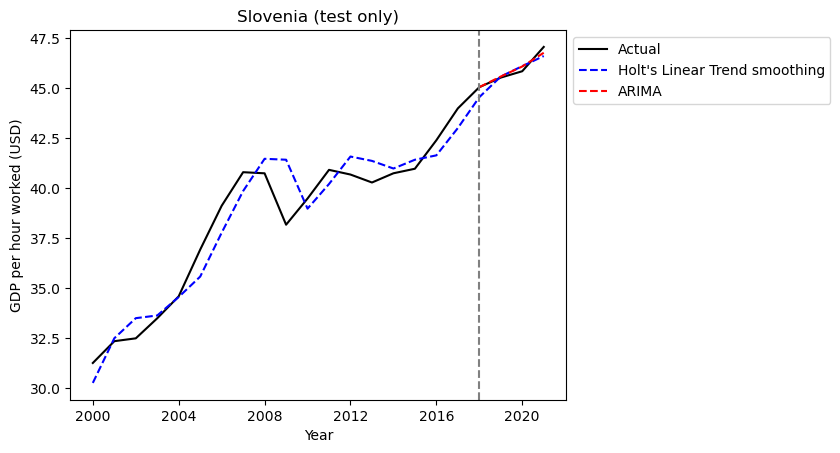

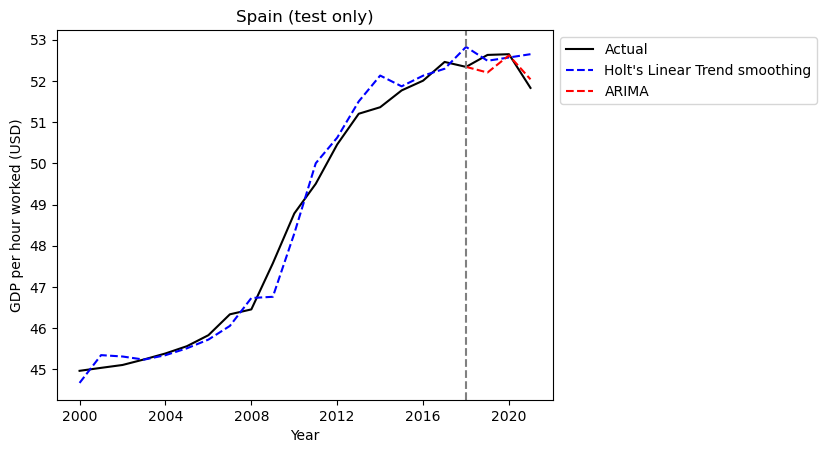

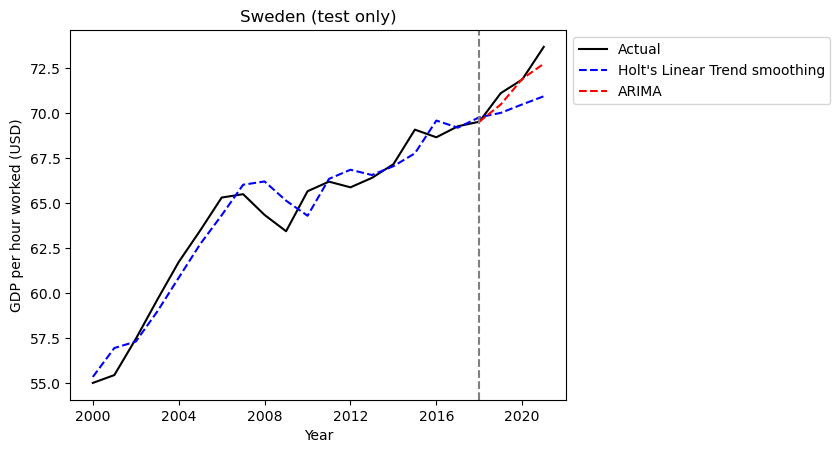

In [35]:
# Plot the data
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue
    
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    country_cfg = country_arima_orders[country]

    plot_exp_smoothing_vs_arima(country+" (test only)", country_series, country_cfg)

Looks a lot more crazy here, but let's actually run it through some correlation coefficients for a numeric comparison between Exponential Smoothing and ARIMA.
Only going to look at correlation coefficients for the test section for ARIMA

In [46]:
# Get correlation coefficient for test and prediction for exponential smoothing and ARIMA
df_results = pd.DataFrame(columns=['Name', 'ExpSmooth corr', 'ARIMA corr', 'ExpSmooth RMSE', 'ARIMA RMSE'])
df_results.set_index('Name', inplace=True)

train_size = year_to_predict - 2000 + 1
test_size = 2021 - year_to_predict

def get_correlation_coefficient(actual, pred):
    df = pd.DataFrame({'actual': actual, 'pred': pred})
    return df.corr().iloc[0, 1]

def get_rmse(actual, pred):
    rmse = 0
    for i in range(len(actual)):
        if actual[i] != np.nan and pred[i] != np.nan:
            rmse += (actual[i] - pred[i]) ** 2
    rmse = np.sqrt(rmse / len(actual))

    if rmse == np.inf:
        return np.nan
    return rmse

def get_correlation_for_series(name, series, cfg=best_cfg):
    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series[:train_size],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(test_size)
    exp_forecast = forecast.values
    exp_corr = get_correlation_coefficient(series[train_size:], exp_forecast)
    exp_rmse = get_rmse(series[train_size:], exp_forecast)

    # ARIMA
    results = run_arima_model(series, cfg)
    predictions = results["predictions"]
    arima_corr = get_correlation_coefficient(series[train_size:], predictions)
    arima_rmse = get_rmse(series[train_size:], predictions)

    
    df_results.loc[name] = [exp_corr, arima_corr, exp_rmse, arima_rmse]

In [47]:
# Get correlation coefficients for mean labour productivity
get_correlation_for_series("Mean", labour_mean_series)

# Get correlation coefficients for each country
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Plot the data
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    get_correlation_for_series(country, country_series, cfg=country_arima_orders[country])

df_results

ExpSmooth corr  ARIMA corr  ExpSmooth RMSE  ARIMA RMSE
Name                                                                  
Mean                  0.991027    0.971306        1.065436    0.364271
Austria               0.761112    0.708762        0.487441    0.590079
Belgium               0.595371    0.287354        1.257308    1.356616
Bulgaria              0.907801    0.624580        0.264545    0.370515
Croatia               0.165035   -0.773100        2.420587    1.828427
Czech Republic        0.934788    0.953696        0.831734    0.168665
Denmark               0.999872    0.994105        0.576855    0.104571
Estonia               0.863748    0.793276        2.095767    0.960338
Finland               0.999326    0.976828        0.849801    0.166975
France               -0.649389   -0.705282        1.015504    0.627282
Germany               0.999480    0.999129        0.314856    0.045627
Greece               -0.055290   -0.029844        1.951426    0.711354
Hungary               0.889432    0.851974        1.527692    0.594286
Ireland               0.960112    0.998059        4.191764    5.741633
Italy                 0.586834    0.980620        1.186483    0.489043
Latvia                0.992785    0.999872        1.612575    0.382082
Lithuania             0.987016    0.957186        2.488090    0.824782
Luxembourg            0.363010   -0.978948        1.324470    1.419535
Netherlands           0.256333   -0.396534        1.465497    0.765701
Poland               -0.444367   -0.718174        1.388137    0.963739
Portugal              0.999611    0.998265        0.546106    0.192901
Romania               0.783754   -0.319836        1.467741    2.266074
Slovakia              0.983824    0.895363        1.798928    0.928806
Slovenia              0.944826    0.972081        0.303155    0.219569
Spain                -0.857593    0.732361        0.481899    0.274868
Sweden                0.970234    0.928856        1.882691    0.651029

In [39]:
# Drop first row and get mean of df_results
df_results.mean(axis=0, numeric_only=True)

ExpSmooth corr    0.612642
ARIMA corr        0.488537
ExpSmooth RMSE    1.338326
ARIMA RMSE        0.884953
dtype: float64

Both Exponential smoothing and ARIMA performed poorly, but ARIMA performed better overall

# Per subregions

In [40]:
# Get mean productivity for each subregion per year
subregions_dict = cLib.get_subregions_data()
subregions = cLib.get_subregions()
countries =  cLib.get_countries()
df_subregions = pd.DataFrame(columns=['SUBREGION', 'YEAR', 'PRODUCTIVITY'])
subregion_productivity = {}
for subregion in subregions:
    for year in range(2000, 2022):
        df_toadd = pd.DataFrame({'SUBREGION': subregion, 'YEAR': year, 'PRODUCTIVITY': 0}, index=[0])
        df_subregions = pd.concat([df_subregions, df_toadd], ignore_index=True)

# Fill empty dataframe with mean of productivity for each subregion
for subregion in subregions:
    subregion_productivity[subregion] = {}
    for year in range(2000, 2022):
        subregion_productivity[subregion][year] = 0

for subregion in subregions:
    for country in subregions_dict[subregion]:
        country_code = cLib.get_country_data(country).alpha3
        df_country = df_formatted[df_formatted['LOCATION'] == country_code]
        for year in range(2000, 2022):
            df_toadd = df_country[df_country['YEAR'] == year]
            if not df_toadd.empty:
                subregion_productivity[subregion][year] += df_toadd['PRODUCTIVITY'].values[0]

for subregion in subregions:
    for year in range(2000, 2022):
        mean_val = subregion_productivity[subregion][year] / len(subregions_dict[subregion])
        df_subregions.loc[(df_subregions['SUBREGION'] == subregion) & (df_subregions['YEAR'] == year), 'PRODUCTIVITY'] = mean_val

df_subregions.head()

SUBREGION  YEAR PRODUCTIVITY
0  Central Europe  2000    34.228938
1  Central Europe  2001     35.40208
2  Central Europe  2002    36.355127
3  Central Europe  2003    37.432391
4  Central Europe  2004    38.496143

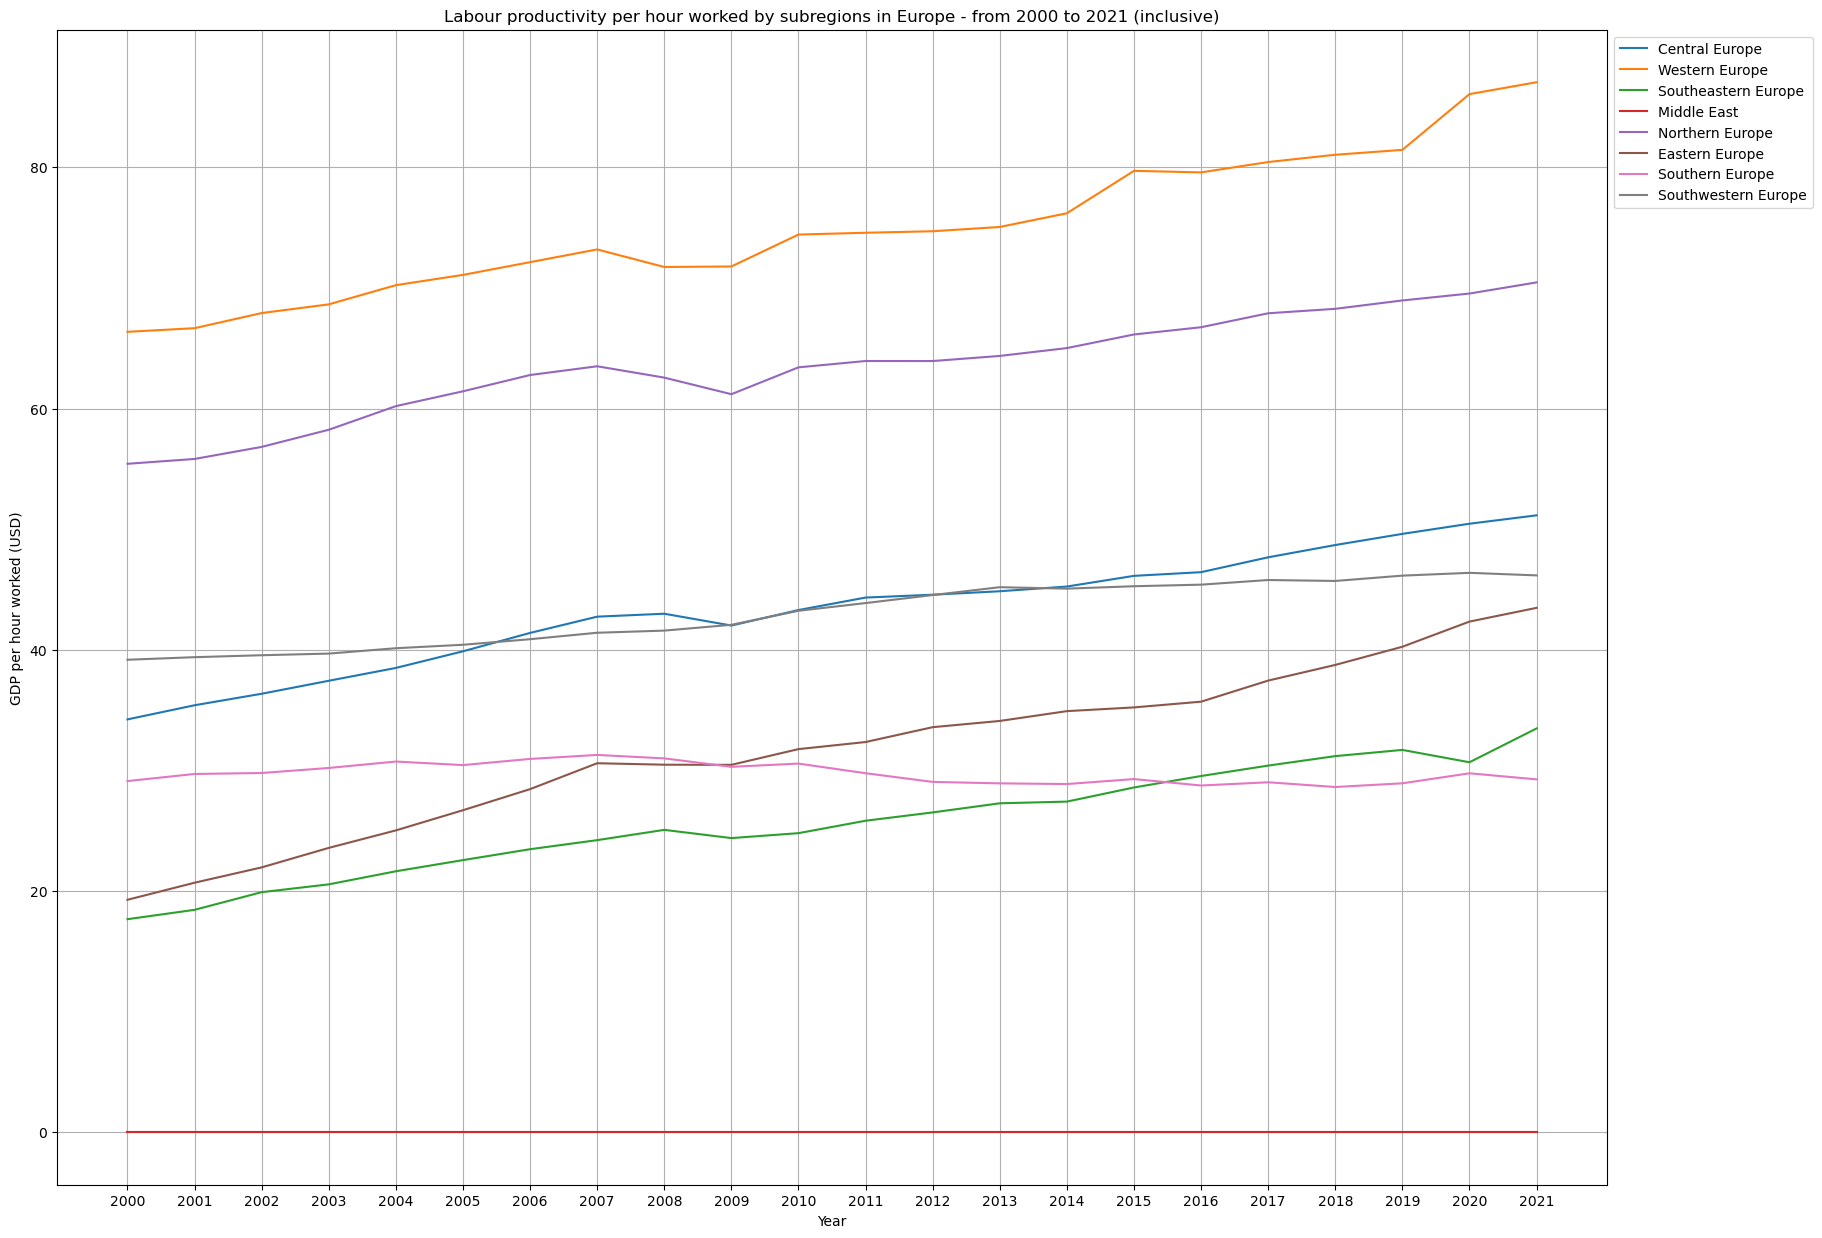

In [41]:
# Plot productivity for each subregion
plt.figure(figsize=(20, 15))
colors = plt.cm.hsv(np.linspace(0, 1, len(subregions)))

for subregion in subregions:
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    plt.plot(df_subregion['YEAR'].astype(str), df_subregion['PRODUCTIVITY'], label=subregion)

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel("Year")
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by subregions in Europe - from 2000 to 2021 (inclusive)")
plt.show()

Best ARIMA(6, 2, 2) MSE=0.006


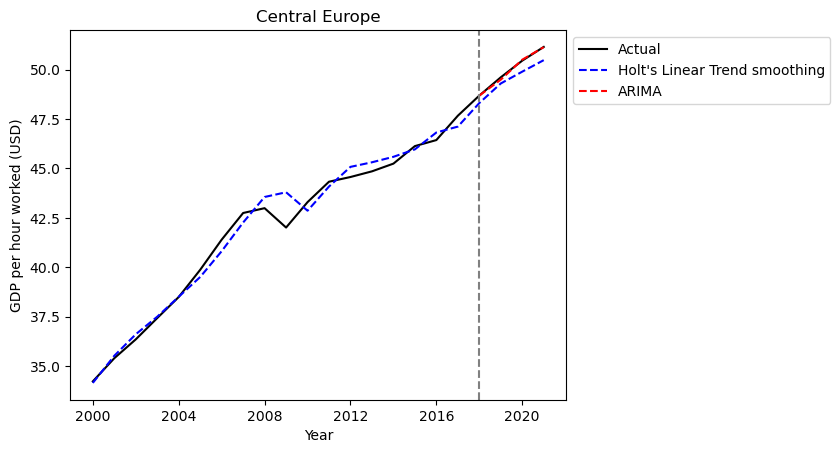

Best ARIMA(6, 2, 0) MSE=1.431


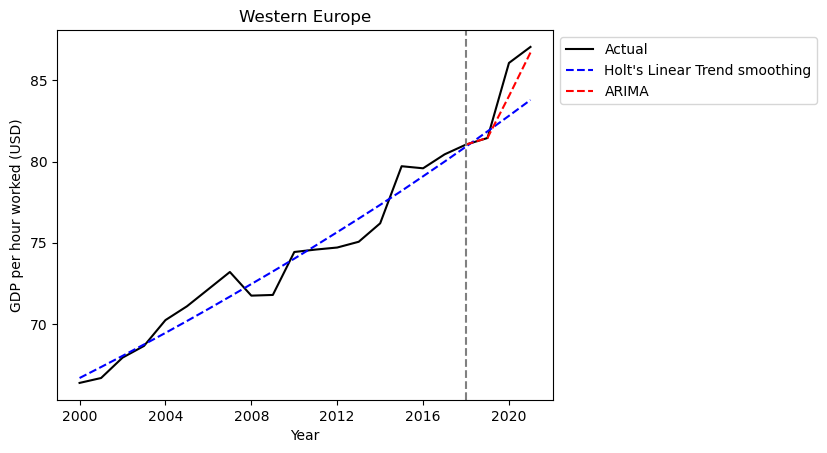

Best ARIMA(10, 2, 0) MSE=1.076


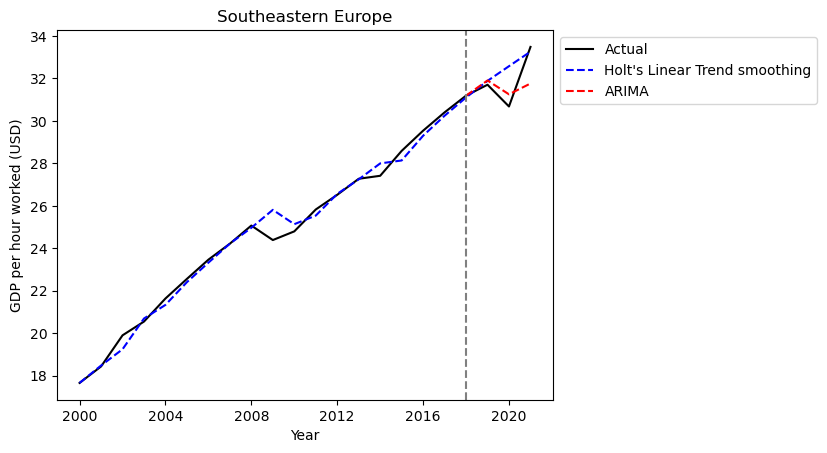

Best ARIMA(6, 2, 2) MSE=0.011


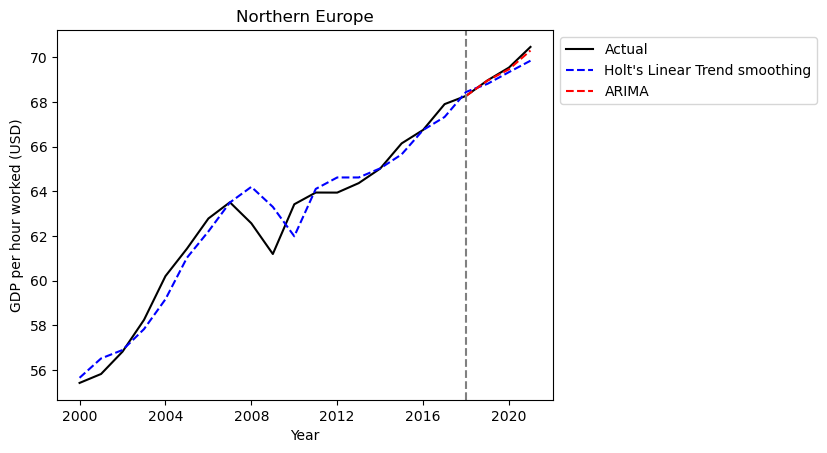

Best ARIMA(4, 1, 2) MSE=0.291


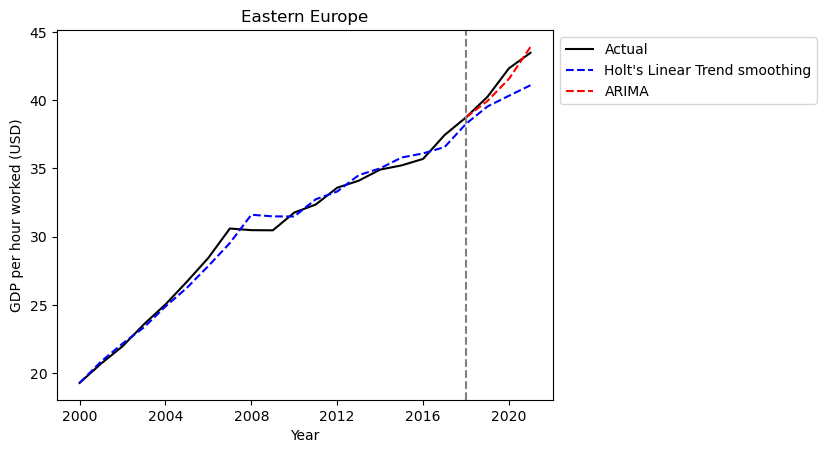

Best ARIMA(0, 0, 1) MSE=0.058


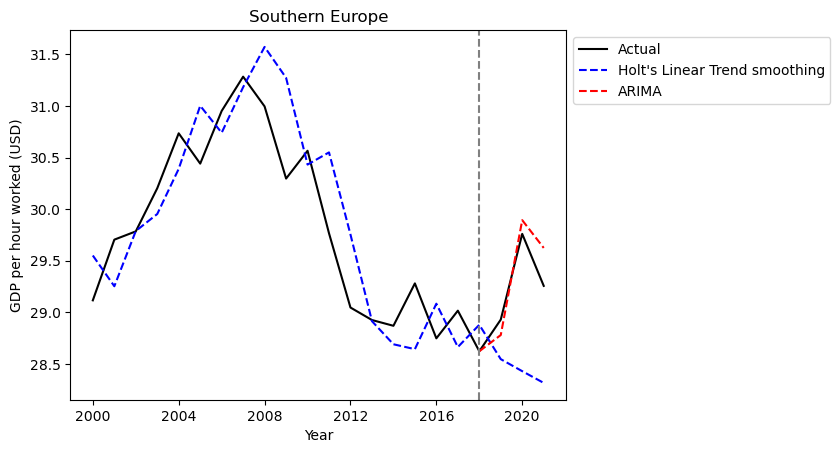

Best ARIMA(4, 1, 2) MSE=0.042


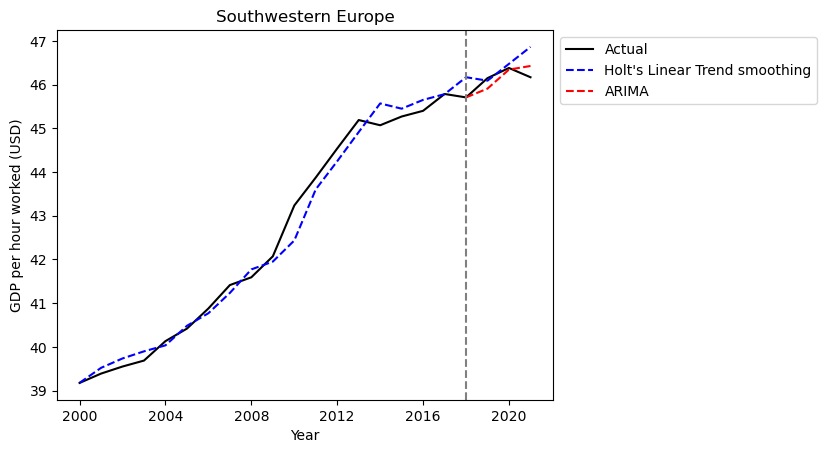

In [42]:
# Predict with both exponential smoothing and ARIMA for each subregion
subregion_arima_orders = {}
for subregion in subregions:
    # Get subregion data and make index the year
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    df_subregion.set_index('YEAR', inplace=True)
    df_subregion.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(df_subregion['PRODUCTIVITY'].values) == 0:
        continue

    subregion_series = pd.Series(df_subregion['PRODUCTIVITY'].values, index=index)
    subregion_series = subregion_series.astype('float64')

    # Exponential Smoothing
    try: # Middle East is constant because no data for Cyprus, so ignore it
        fit = ExponentialSmoothing(
            subregion_series,
            trend="add",
            use_boxcox=True,
            initialization_method="estimated"
        ).fit()
    except:
        continue
    forecast = fit.forecast(2021-year_to_predict)
    exp_forecast = forecast.values

    # ARIMA
    subregion_cfg = evaluate_models(subregion_series, p_values, d_values, q_values)
    subregion_arima_orders[subregion] = subregion_cfg

    # Plot the data
    plot_exp_smoothing_vs_arima(subregion, subregion_series, subregion_cfg)

In [48]:
# Get correlation coefficient for test and prediction for exponential smoothing and ARIMA
df_results = pd.DataFrame(columns=['Name', 'ExpSmooth corr', 'ARIMA corr', 'ExpSmooth RMSE', 'ARIMA RMSE'])
df_results.set_index('Name', inplace=True)

# Get correlation coefficients for mean labour productivity
get_correlation_for_series("Mean", labour_mean_series)

for subregion in subregions:
    # Get subregion data and make index the year
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    df_subregion.set_index('YEAR', inplace=True)
    df_subregion.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(df_subregion['PRODUCTIVITY'].values) == 0 or subregion not in subregion_arima_orders:
        continue

    subregion_series = pd.Series(df_subregion['PRODUCTIVITY'].values, index=index)
    subregion_series = subregion_series.astype('float64')
    get_correlation_for_series(subregion, subregion_series, subregion_arima_orders[subregion])
df_results

ExpSmooth corr  ARIMA corr  ExpSmooth RMSE  ARIMA RMSE
Name                                                                       
Mean                       0.991027    0.971306        1.065436    0.364271
Central Europe             0.998865    0.997152        0.533716    0.074369
Western Europe             0.934542    0.932231        2.674312    1.196429
Southeastern Europe        0.625948    0.631290        1.106861    1.053879
Northern Europe            0.989905    0.999973        0.385952    0.103304
Eastern Europe             0.986840    0.963123        1.844687    0.538649
Southern Europe           -0.396549    0.916209        0.966199    0.241737
Southwestern Europe        0.076900    0.438446        0.405753    0.204337

In [49]:
# Drop first row and get mean of df_results
df_results.drop(df_results.index[0], inplace=True)
df_results.mean()

ExpSmooth corr    0.602350
ARIMA corr        0.839775
ExpSmooth RMSE    1.131069
ARIMA RMSE        0.487529
dtype: float64

Interestingly it performed a lot better for the subregions, but that might be because of the noise from each individual country